# Simulation of optimized pupil mask for VLT/ZIMPOL

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

% matplotlib notebook

from telescopeSim import *

204


/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


<IPython.core.display.Javascript object>


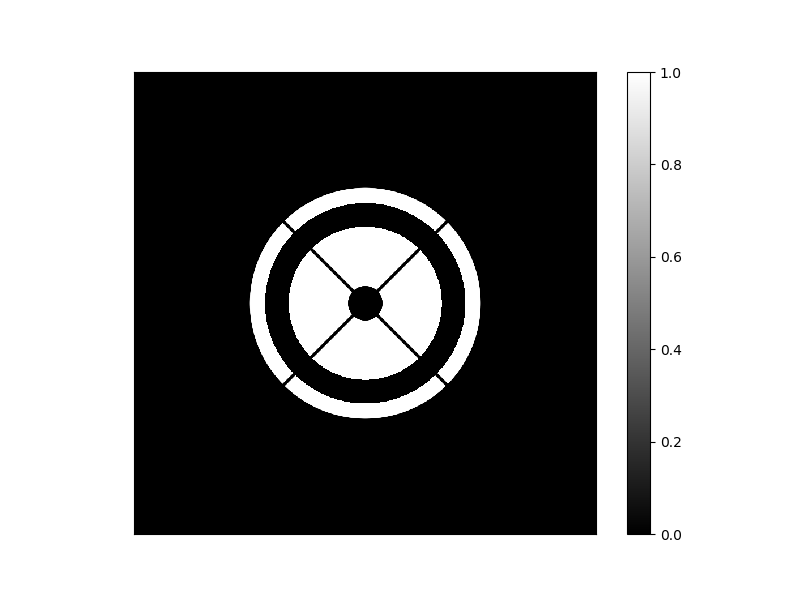

In [3]:
lD = 10
apRad = int(N/(2*lD))
print(apRad)
EP = make_VLT_pupil(1024, apRad, spiders=False)
x = np.arange(-512, 512)
y = np.arange(-512, 512)
XX, YY = np.meshgrid(x,y)

X,Y = np.meshgrid(np.arange(-N/2, N/2),np.arange(-N/2, N/2))
RHO, THETA = cart2pol(X,Y)
Rho, Theta = cart2pol(XX, YY)

a,b = 0.765, 0.205
EPopt = EP.copy()
spWidth = 0.02
EPopt[np.where((Rho>(a-0.5*b)*apRad) & (Rho<(a+0.5*b)*apRad))]=0
#EPopt*= (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/(Rin))**500))
EPopt *= (1 - np.exp(-((XX+YY)/(spWidth*apRad))**10))*(1 - np.exp(-((XX-YY)/(spWidth*apRad))**10))
#EP *= (1 - np.exp(-((XX+YY)/(spWidth*apRad))**10))*(1 - np.exp(-((XX-YY)/(spWidth*apRad))**10))
EP = np.lib.pad(EP, (1536, 1536), 'constant', constant_values=(0,0))
EPopt = np.lib.pad(EPopt, (1536, 1536), 'constant', constant_values=(0,0))
#EP = np.lib.pad(EP, (1024, 1024), 'constant', constant_values=(0,0))
#EPopt = np.lib.pad(EPopt, (1024, 1024), 'constant', constant_values=(0,0))
#EPopt = np.roll(EPopt, 30, axis=1)
#EPopt = np.roll(EPopt,30, axis=0)*EP
plot_im_LP(EPopt, apRad, 1)
plt.yticks([])
plt.xticks([])
savepath = "/Users/patapisp/Documents/DAC/ZIMPOL_Mask/SPIE_paper/"
#plt.savefig(savepath+"PupilMask_opt.pdf",dpi=300, format='pdf', transparent=True)

<IPython.core.display.Javascript object>


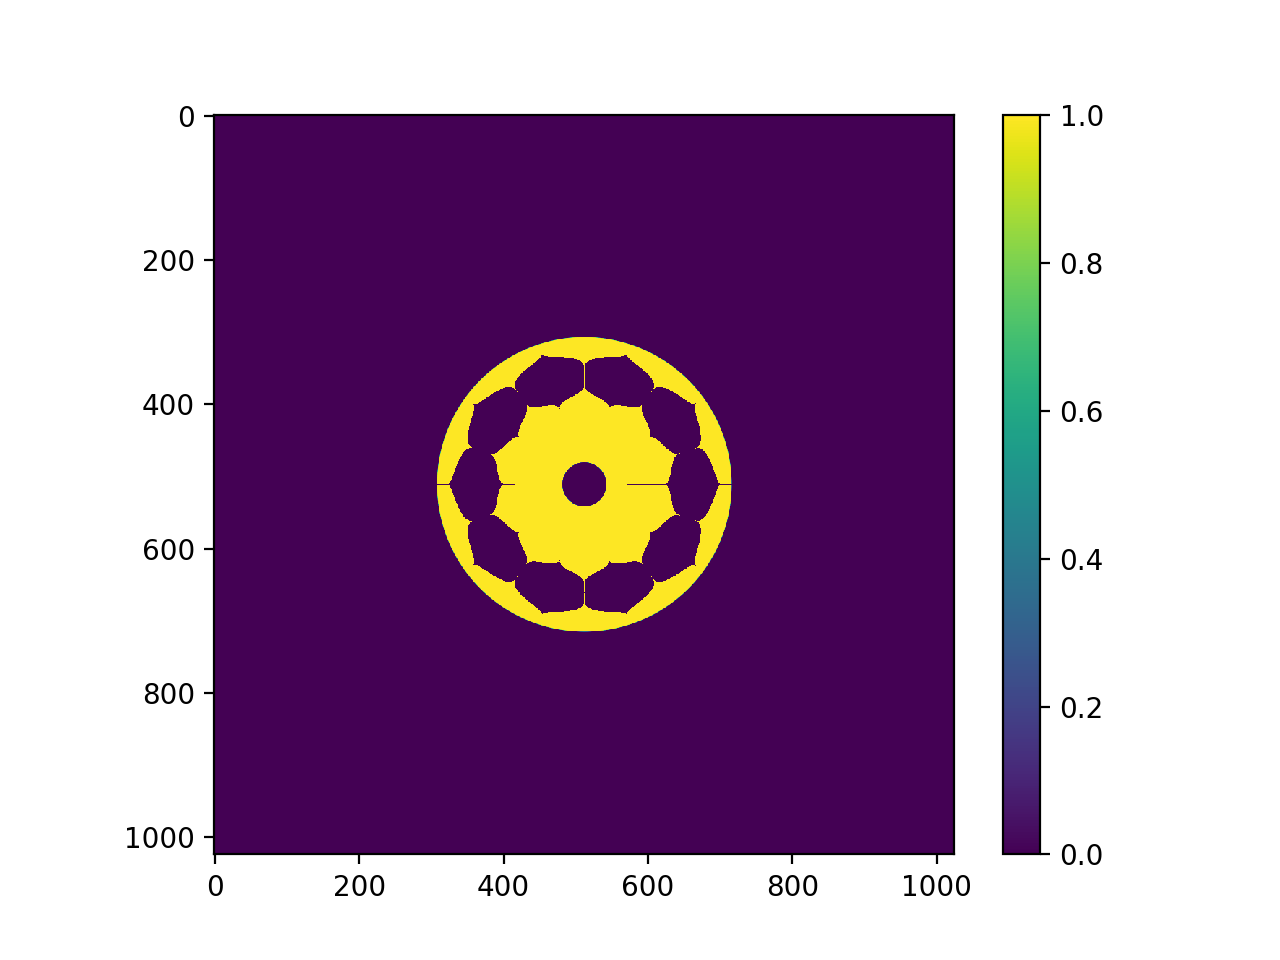

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


In [47]:
def A_ss(rho, a, b, n):
    return 1-np.exp(-((rho-a)/b)**n)

def T_P(rho, a, b, n, P):
    return (2*np.pi/P)*A_ss(rho, a, b, n)

def theta_opaq(rho, a, b, n, P, q):
    return 2*np.pi*q/P + (np.pi/P)*np.exp(-((rho-a)/b)**n), 2*np.pi*q/P - (np.pi/P)*np.exp(-((rho-a)/b)**n)

ss = np.ones_like(Rho)
P=20
for q in np.arange(-int(P/2), int(P/2)):
    angu, angl = theta_opaq(Rho, 150, 30, 6, 10, q)
    ss[np.where((Theta<=angu) & (Theta>angl))] = 0
plt.figure()
plt.imshow(ss*make_VLT_pupil(1024, apRad, spiders=False))
plt.colorbar()

def make_starshade(p, rho):
    a, b = p
    n = 6
    P = 10
    ss = np.ones_like(rho)
    for q in np.arange(-int(P/2), int(P/2)):
        angu, angl = theta_opaq(Rho, a, b, n, P, q)
        ss[np.where((Theta<=angu) & (Theta>angl))] = 0
    return ss
    
def min_starshade_function(p, rho, EPfunc, calib, ROIhole, ROIpeak):
    ss = make_starshade(p, rho)
    EPss = np.lib.pad(ss*EPfunc, (1536, 1536), 'constant', constant_values=(0,0))
    PSFss = np.abs(myfft2(EPss))**2
    PSFss = PSFss/calib
    hole = np.sum(PSFss*ROIhole)
    peak = np.sum(PSFss*ROIpeak)
    return -np.log(hole/np.sum(ROIhole))#+np.log(peak/np.sum(ROIpeak))

In [25]:
OPT_REG_FP = np.zeros((1024,1024))
OPT_REG_FP[np.where(Rho<2.5*lD)] = 1
OPT_REG_FP[np.where(Rho<1.5*lD)] = 0
ROIhole = np.lib.pad(OPT_REG_FP, (1536, 1536), 'constant', constant_values=(0,0)) 

ROIpeak  = np.zeros((1024,1024))
ROIpeak[np.where(Rho<1.*lD)] = 1
ROIpeak = np.lib.pad(ROIpeak, (1536, 1536), 'constant', constant_values=(0,0)) 

In [6]:
from scipy.optimize import minimize

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


<IPython.core.display.Javascript object>


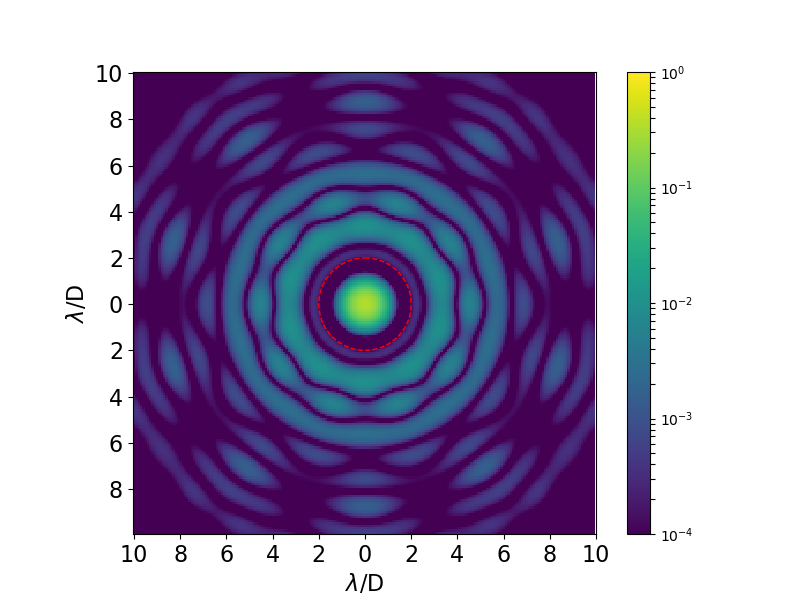

0.34659557858463164


In [23]:
PSF = np.abs(myfft2(EP))**2
calib = np.max(PSF)
EPss = np.lib.pad(ss*make_VLT_pupil(1024, apRad, spiders=False), (1536, 1536), 'constant', constant_values=(0,0))
PSFss = np.abs(myfft2(EPss))**2
plot_im_ld(PSFss/calib, lD, 10, log_scale=True, log_min=-4)
plt.xlabel("$\lambda$/D", fontsize=16)
plt.ylabel("$\lambda$/D", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
print(np.max(PSFss/calib))

In [44]:
print(min_starshade_function([150., 30.], Rho, make_VLT_pupil(1024, apRad, spiders=False), calib, ROIhole, ROIpeak))

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


5.7134502075611096


In [48]:
bnds = ((135, 165), (20, 40))
res = minimize(min_starshade_function, [150., 30.], args=(Rho, make_VLT_pupil(1024, apRad, spiders=False), calib, ROIhole, ROIpeak),
               method='TNC',options={"maxiter":20,"disp":True}, bounds=bnds)

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


In [ ]:
res = np.zeros(shape=(20,20))
for i,a in enumerate(np.arange(140, 160)):
    for j,b in enumerate(np.arange(20, 40)):
        res[i,j] = min_starshade_function([a, b], Rho, make_VLT_pupil(1024, apRad, spiders=False), calib, ROIhole, ROIpeak)
        
plt.figure()
plt.imshow(res, origin='lower')

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


<IPython.core.display.Javascript object>


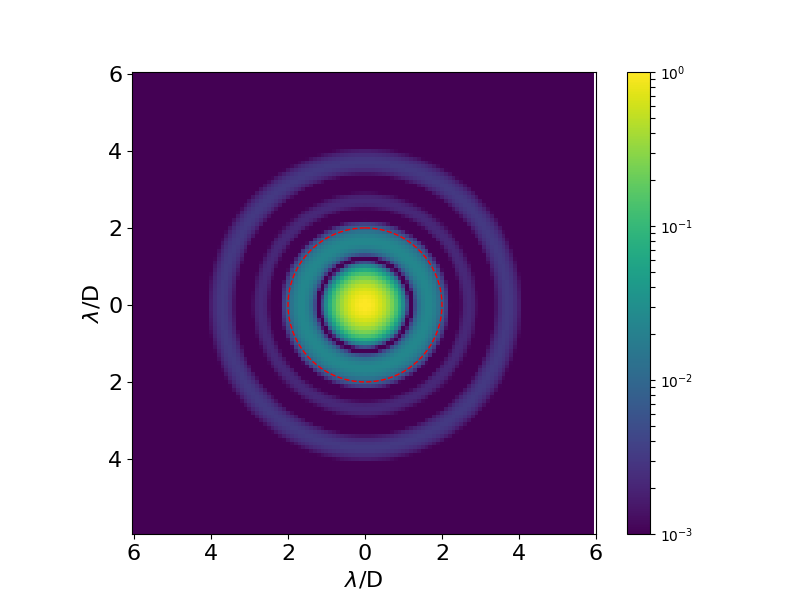

0.43101834085262697


In [3]:
PSF = np.abs(myfft2(EP))**2
calib = np.max(PSF)
PSFopt = np.abs(myfft2(EPopt))**2
PSFopt /= calib
plot_im_ld(PSF/calib, lD, 6, log_scale=True, log_min=-3)
plt.xlabel("$\lambda$/D", fontsize=16)
plt.ylabel("$\lambda$/D", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
print(np.max(PSFopt))
#plt.savefig(savepath+"PSFVLT.pdf", dpi=300, format='pdf', transparent=True)

<IPython.core.display.Javascript object>


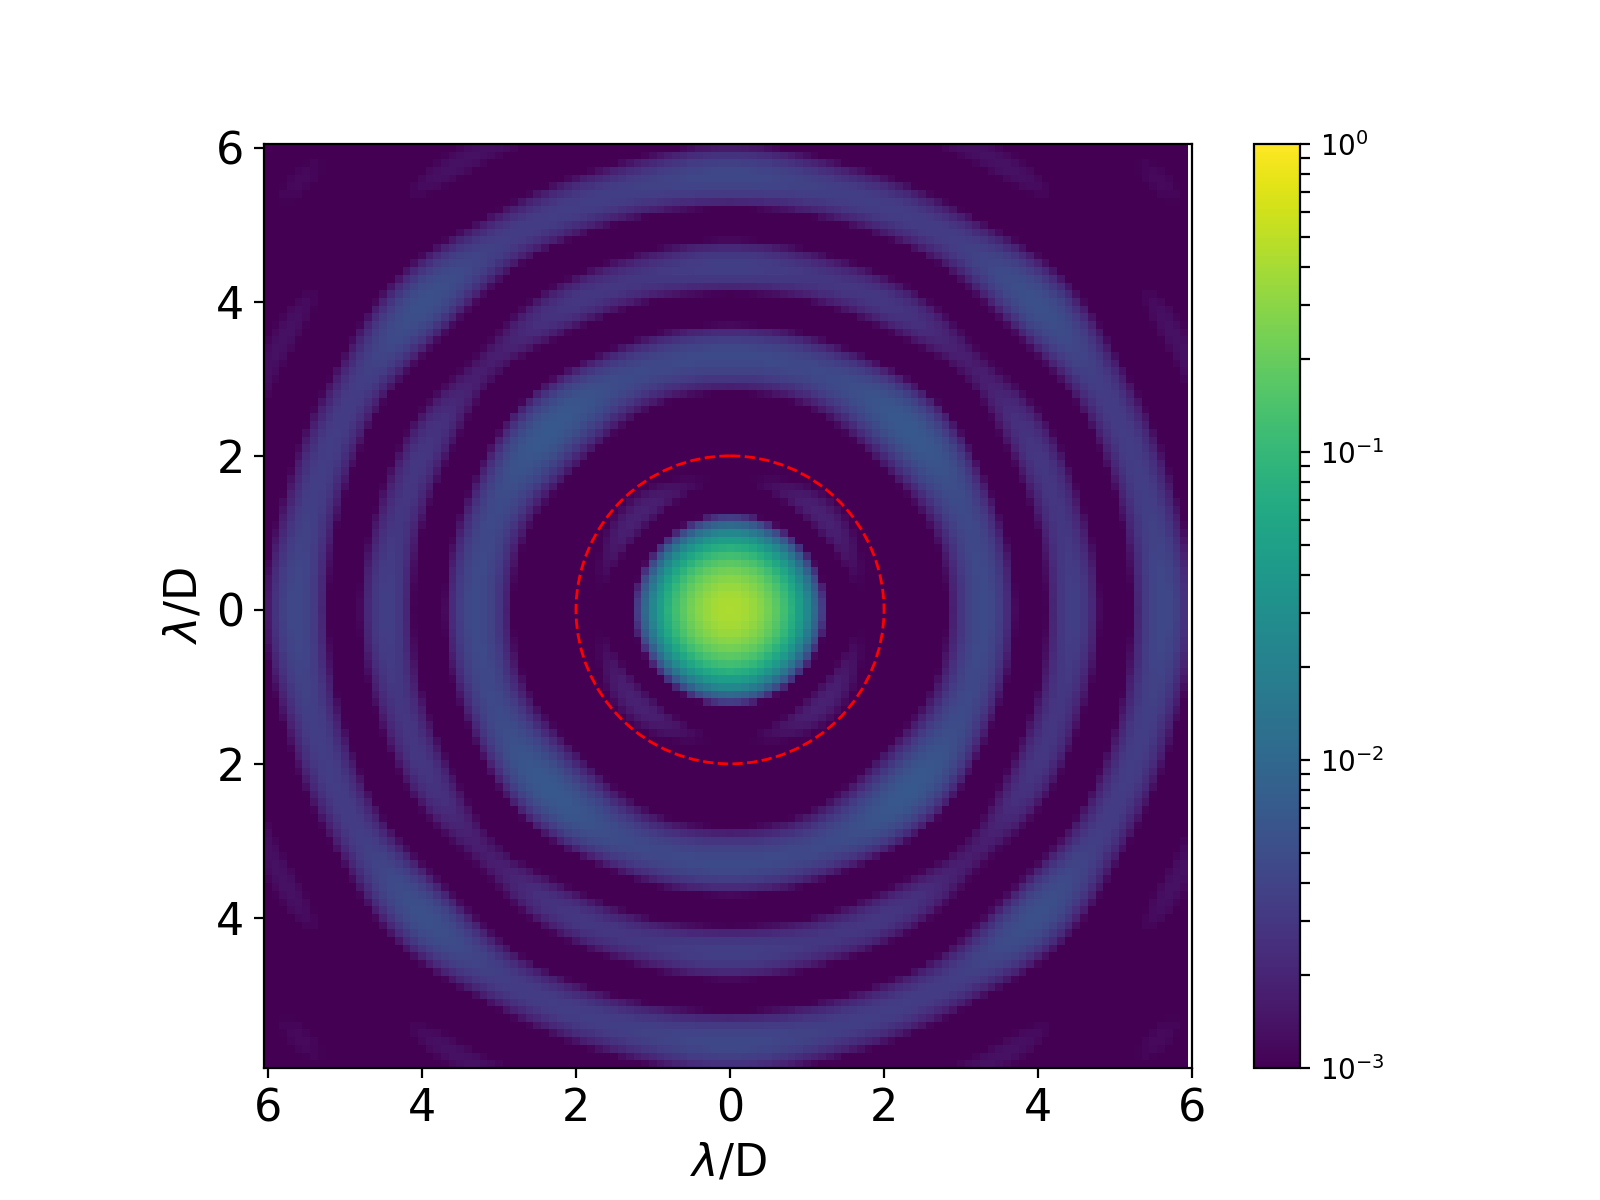

(array([  0,  20,  40,  60,  80, 100]), <a list of 6 Text yticklabel objects>)

In [5]:
plot_im_ld(PSFopt, lD, 6, log_scale=True, log_min=-3)
plt.xlabel("$\lambda$/D", fontsize=16)
plt.ylabel("$\lambda$/D", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig(savepath+"PSFRing_spiders45.pdf", dpi=300, format='pdf', transparent=True)

In [13]:
def modified_GS(EP, optEPinit, OPT_REG_FP, max_its):
    PSF = myfft2(EP)
    count = 0
    init_amplitude = np.sum(np.sum(PSF*OPT_REG_FP)**2)
    amplitudes = []
    EPj = optEPinit
    while count < max_its:
        count += 1
        PSFj = myfft2(EP*EPj)
        a = np.sum(np.sum(np.real(PSFj*OPT_REG_FP))**2)/init_amplitude
        amplitudes.append(a)
        PSFj *= (1-OPT_REG_FP)
        CEPj = myifft2(PSFj)
        CEPj = abs(CEPj)
        EPj = CEPj + (1 - EP)
        
        
    plt.semilogy(np.arange(len(amplitudes)), amplitudes, 'o')
    return EPj, amplitudes[-1]

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


<IPython.core.display.Javascript object>


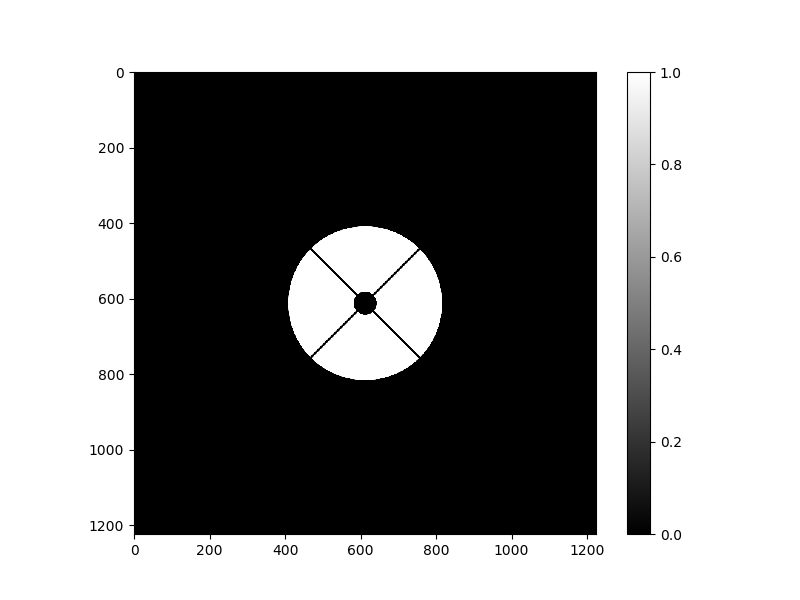

In [5]:
EP2 = make_VLT_pupil(1024, apRad, spiders=False)*(1 - np.exp(-((XX+YY)/(spWidth*apRad))**10))*(1 - np.exp(-((XX-YY)/(spWidth*apRad))**10))
EP2 = np.lib.pad(EP2, (1536, 1536), 'constant', constant_values=(0,0))
plot_im_LP(EP2, apRad, 2)
#plt.savefig("Simulations/VLT-EPupil_spiders45.ps", dpi=100,format="ps")

<IPython.core.display.Javascript object>


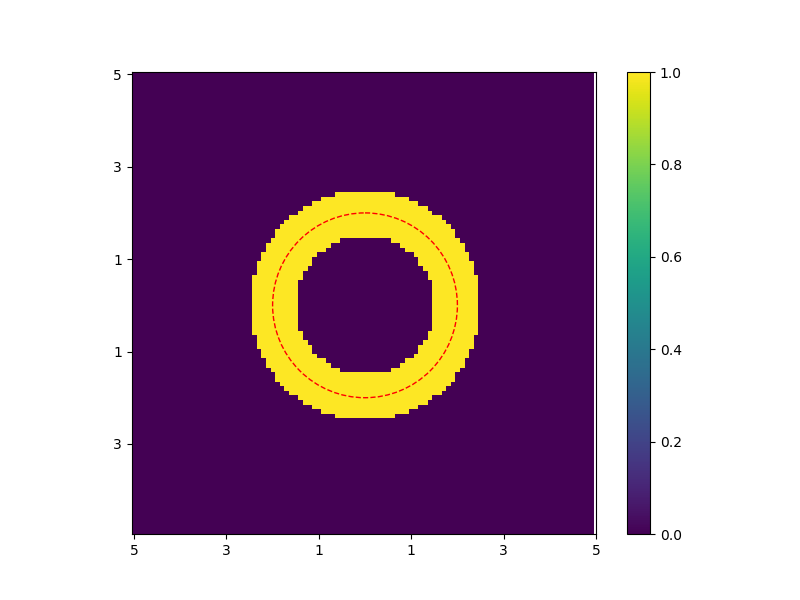

In [4]:
OPT_REG_FP = np.zeros((1024,1024))
OPT_REG_FP[np.where(Rho<2.5*lD)] = 1
OPT_REG_FP[np.where(Rho<1.5*lD)] = 0
OPT_REG_FP = np.lib.pad(OPT_REG_FP, (1536, 1536), 'constant', constant_values=(0,0))
plot_im_ld(OPT_REG_FP, lD, 5)

In [19]:
print(np.mean(PSF[np.where(OPT_REG_FP==1)]/calib), np.mean(PSFopt[np.where(OPT_REG_FP==1)]), np.sum(PSFopt[np.where(OPT_REG_FP==1)])/np.sum(PSF[np.where(OPT_REG_FP==1)]/calib))

0.009636881500757546 0.0005524434555865908 0.057325957110001165


<IPython.core.display.Javascript object>


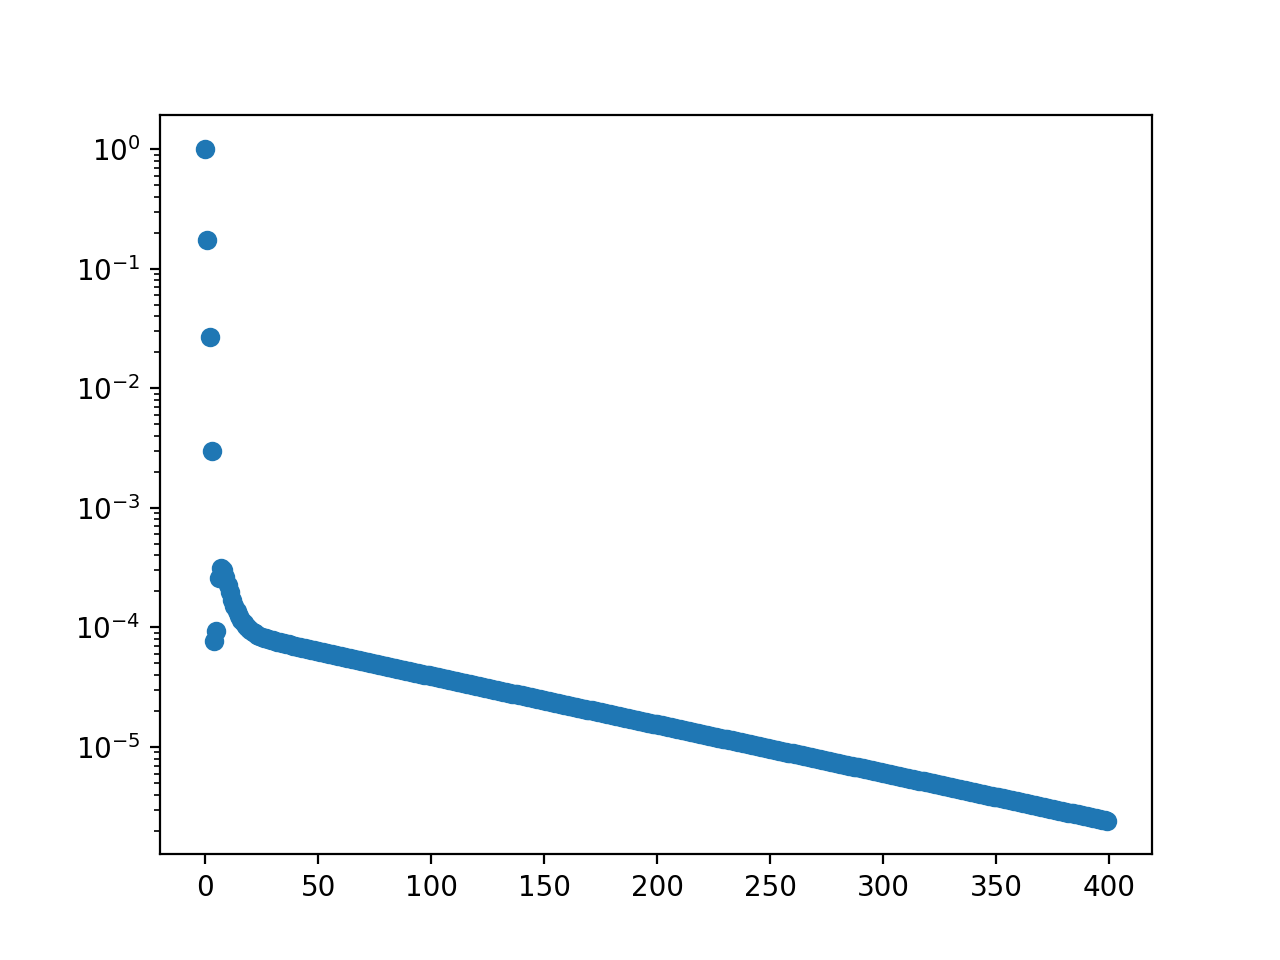

/Users/patapisp/anaconda2/envs/python35/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [20]:
optEP, ampl = modified_GS(EP2, EP2, OPT_REG_FP, 400)

In [15]:
optEP = fits.getdata('ZIMPOL_optPupil_spiders_grayscale.fits')

<IPython.core.display.Javascript object>


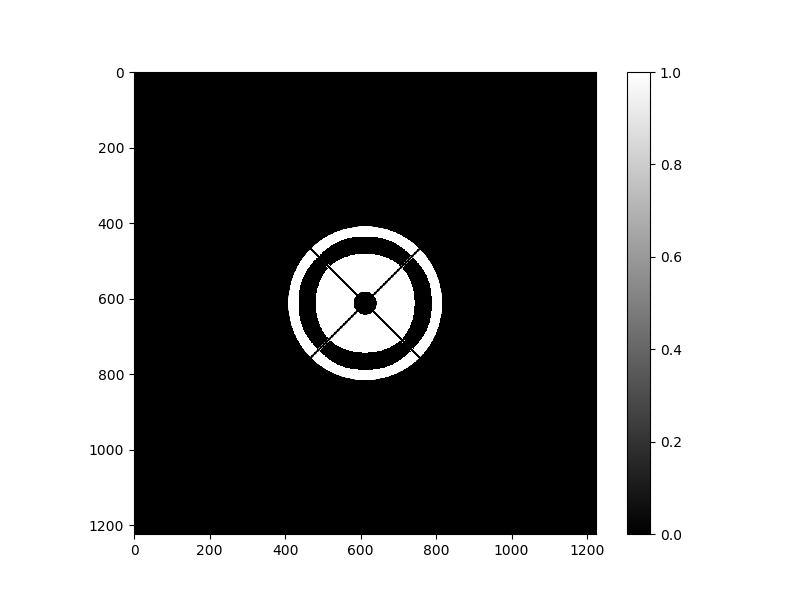

In [16]:
newEP = np.abs(optEP)
optEP_bin = np.zeros((N,N))
optEP_bin[np.where(newEP <= 0.33)] = 0
optEP_bin[np.where(newEP > 0.33)] = 1

plot_im_LP(optEP_bin*EP2, apRad, 2)

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


<IPython.core.display.Javascript object>


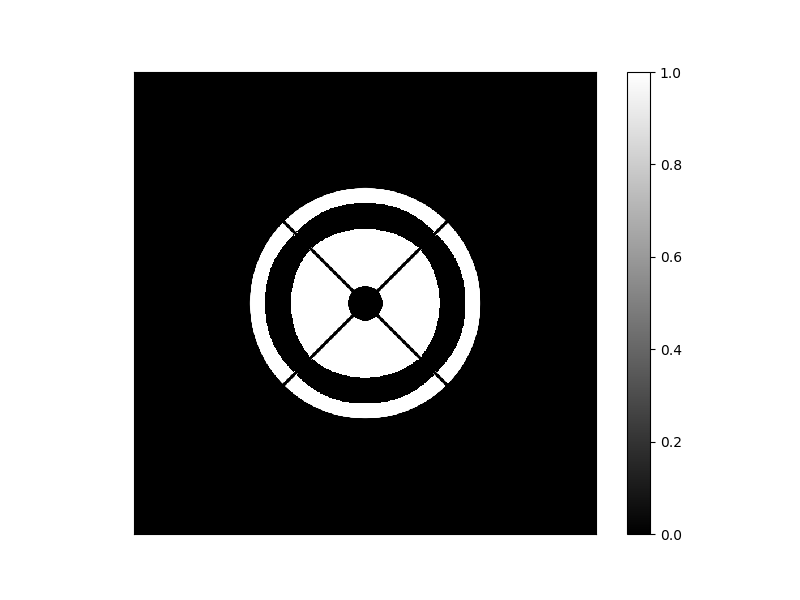

In [18]:
#EPopt_2 = fits.getdata("opt_mask_400iter_spiders.fits")
#EPopt_2[np.where(EPopt_2<=0.3)] = 0
#EPopt_2[np.where(EPopt_2 > 0)] = 1
plot_im_LP(optEP_bin*optimized_VLT_pupil(apRad, a=0.76, b=0.17, spiders=False)*EP2, apRad, 1)
plt.yticks([])
plt.xticks([])
#plt.savefig(savepath+"OptPupil_optimizedforSPiders.pdf",dpi=300, format='pdf', transparent=True)

136.3/204, 168.2/204

(0.15499999999999992, 0.7475)

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


<IPython.core.display.Javascript object>


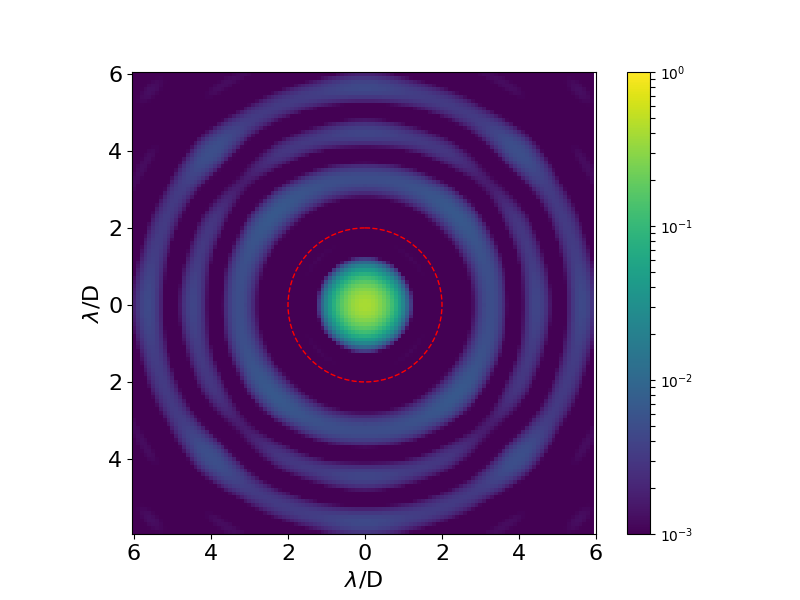

0.41028437569886


In [28]:
EPopt_2 = optEP_bin*optimized_VLT_pupil(apRad, a=0.76, b=0.17, spiders=False)*EP2
PSFopt_2 = np.abs(myfft2(EPopt_2))**2
PSFopt_2 /= calib
plot_im_ld(PSFopt_2, lD, 6, log_scale=True, log_min=-3)
print(np.max(PSFopt_2))
plt.xlabel("$\lambda$/D", fontsize=16)
plt.ylabel("$\lambda$/D", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(savepath+"PSF_optimizedforSiders.pdf",dpi=300, format='pdf', transparent=True)

In [16]:
hdu = fits.PrimaryHDU(data=PSF/calib)
hdu.writeto("PSFopt_no.fits")

In [21]:
start = 2048
end = 2088
psf1d = np.array([np.median(PSF[np.where(RHO == r)]) for r in np.arange(0,40)])/calib
psfopt1d = np.array([np.median(PSFss[np.where(RHO == r)]) for r in np.arange(0,40)])/calib
#psfopt1d_simple = np.array([np.median(PSFopt[np.where(RHO == r)]) for r in np.arange(0,40)])
r = np.arange(0,40)
"""
r,contrast = compute_contrast_curve(PSF, 5, 1, 10, 2)
r,contrast_opt = compute_contrast_curve(PSFopt_2, 5, 1, 10, 2)
r,contrast_opt_simple = compute_contrast_curve(PSFopt, 5, 1, 10, 2)"""




'\nr,contrast = compute_contrast_curve(PSF, 5, 1, 10, 2)\nr,contrast_opt = compute_contrast_curve(PSFopt_2, 5, 1, 10, 2)\nr,contrast_opt_simple = compute_contrast_curve(PSFopt, 5, 1, 10, 2)'

<IPython.core.display.Javascript object>


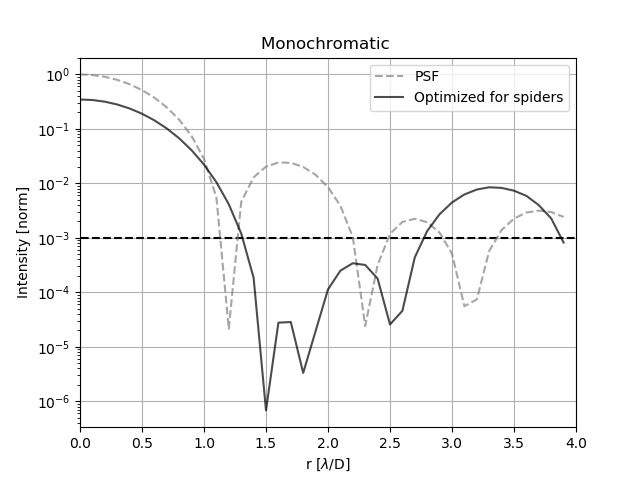

In [22]:
#plt.style.use("seaborn-white")
r = np.arange(0,40)/10
plt.semilogy(r, psf1d, 'gray',linestyle='--',linewidth=1.5, alpha=0.7, label="PSF")
#plt.semilogy(r, psfopt1d_simple,'gray', linewidth=1.5, alpha=0.7, label="Optimized for secondary")
plt.semilogy(r, psfopt1d,'black', linewidth=1.5, alpha=0.7, label="Optimized for spiders")
plt.grid(True)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Intensity [norm]")
plt.title("Monochromatic ")
plt.legend()
plt.hlines(1e-3, 0.01, 4,linestyles='--', colors="black")
plt.xlim([0,4])
plt.gca().fill(np.arange(1.5,2.5,0.5), np.arange(0, 1, 0.5), 'b')

In [ ]:
r = np.arange(0,40)/10
fig, ax = plt.subplots(figsize=(8,6))
plt.semilogy(r, psf1d, 'gray',linewidth=1.5, alpha=0.7, label="PSF")
plt.semilogy(r, psfopt1d,'black', linewidth=1.5, alpha=0.7, label="Opt PSF")
plt.xlabel("r [l/D]")
plt.ylabel("Intensity [norm]")
plt.title("Monochromatic ")
plt.legend()

## Broadband

In [43]:
lc = 750
source_spectrum = np.ones(100)
filter_trans = np.ones(100)
c = []
copt = []
results_psf = []
results_psfopt = []
for width in [int(lc*f) for f in [0.1,0.2,0.3, .4, .5]]:
    psf, psfopt = polychromaticPSF(apRad, N, lc, [width] ,int(width/10.), source_spectrum, filter_trans, RHO, 
                               strehl=1, samples=None, aberration=False)
    results_psf.append(psf)
    results_psfopt.append(psfopt)
    c.append(np.array([np.mean(psf[np.where(RHO == r)]) for r in np.arange(0,40)]))
    copt.append(np.array([np.mean(psfopt[np.where(RHO == r)]) for r in np.arange(0,40)]))



Wavelength range [nm] 712.500000 - 787.500000
Calculating PSF for VLT @712.500000 nm..


/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


Calculating PSF for VLT @725.000000 nm..
Calculating PSF for VLT @737.500000 nm..
Calculating PSF for VLT @750.000000 nm..
Calculating PSF for VLT @762.500000 nm..
Calculating PSF for VLT @775.000000 nm..
Calculating PSF for VLT @787.500000 nm..
Done. Normalizing..
Wavelength range [nm] 675.000000 - 825.000000
Calculating PSF for VLT @675.000000 nm..
Calculating PSF for VLT @685.714286 nm..
Calculating PSF for VLT @696.428571 nm..
Calculating PSF for VLT @707.142857 nm..
Calculating PSF for VLT @717.857143 nm..
Calculating PSF for VLT @728.571429 nm..
Calculating PSF for VLT @739.285714 nm..
Calculating PSF for VLT @750.000000 nm..
Calculating PSF for VLT @760.714286 nm..
Calculating PSF for VLT @771.428571 nm..
Calculating PSF for VLT @782.142857 nm..
Calculating PSF for VLT @792.857143 nm..
Calculating PSF for VLT @803.571429 nm..
Calculating PSF for VLT @814.285714 nm..
Calculating PSF for VLT @825.000000 nm..
Done. Normalizing..
Wavelength range [nm] 637.500000 - 862.500000
Calcula

In [ ]:
### plot_im_ld(results_psf[-1], lD, 5, log_scale=True, log_min=-3)
plt.xlabel("$\lambda$/D")
plt.ylabel("$\lambda$/D")

<IPython.core.display.Javascript object>


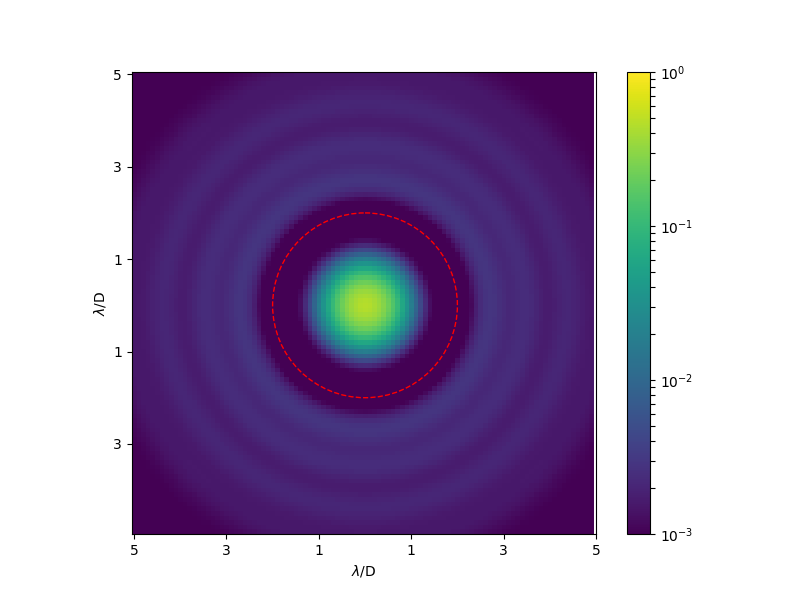

In [44]:
plot_im_ld(results_psfopt[-1], lD, 5, log_scale=True, log_min=-3)
plt.xlabel("$\lambda$/D")
plt.ylabel("$\lambda$/D")

<IPython.core.display.Javascript object>


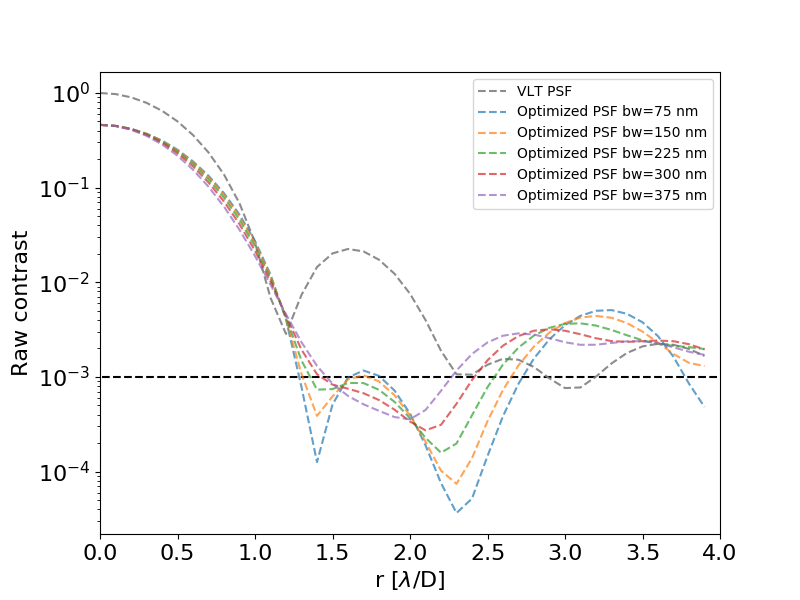

In [46]:
r = np.arange(0,40)/10
fig, ax = plt.subplots(figsize=(8,6))
ax.semilogy(r, c[1], 'gray',linestyle='--',linewidth=1.5, alpha=0.9, label="VLT PSF")
width = [0.1,0.2,0.3, .4, .5]
contrastROI = []
for i in  range(5):
    contrastROI.append(np.sum(results_psfopt[i][OPT_REG_FP==1])/np.sum(results_psf[i][OPT_REG_FP==1]))
    w = int(width[i]*750)
    ax.semilogy(r, copt[i],linestyle='--',linewidth=1.5, alpha=0.7, label="Optimized PSF bw=%i nm"%(w))
ax.set_xlabel("r [$\lambda$/D]",fontsize=16)
ax.set_ylabel("Raw contrast", fontsize=16)
ax.legend()
ax.set_xlim([0,4])
ax.hlines(1e-3, 0.01, 4,linestyles='--', colors="black")    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(savepath+"Broadband_contrast.pdf",dpi=300, format='pdf', transparent=True)

<IPython.core.display.Javascript object>


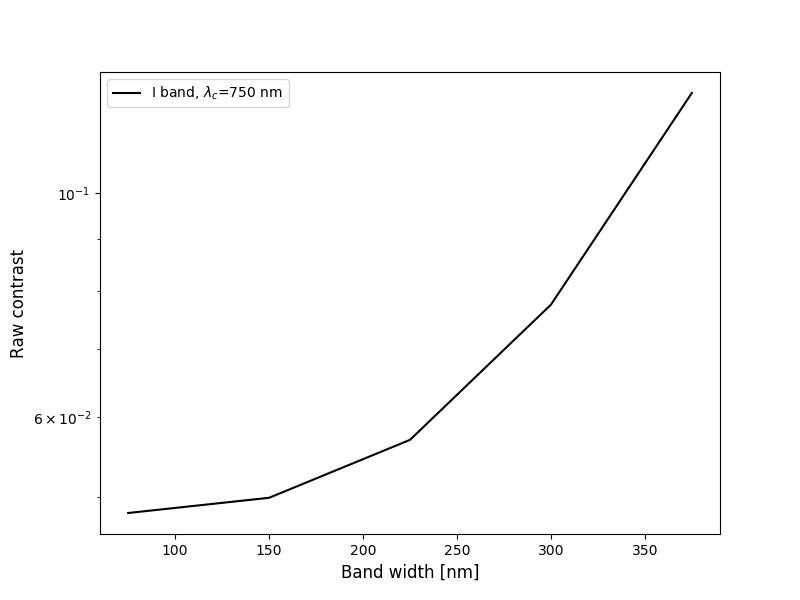

[0.048157901568444496, 0.049860465268771234, 0.056917733975693885, 0.07750847120490571, 0.12572698711442568]


In [51]:
plt.figure(figsize=(8,6))
plt.semilogy(np.array(width)*lc, contrastROI, 'black', label='I band, $\lambda_c$=750 nm')
plt.xlabel("Band width [nm]",fontsize=12)
plt.ylabel("Raw contrast", fontsize=12)
plt.legend()
print(contrastROI)
plt.savefig(savepath+"Bandwidth_contrast_degradation.pdf",dpi=300, format='pdf', transparent=True)

In [53]:
0.4*1/0.049860465268771234

8.022388035165996

In [19]:
PSF750 = np.abs(myfft2(EP))**2
PSF1000 = np.abs(myfft2(polychromaticEP(VLT_pupil, apRad=apRad, l=1000, lc=750, RHO=RHO, strehl=1.0, N=N,samples=None)))**2

PSF750 /= np.max(PSF750)
PSF1000 /= np.max(PSF1000)

psf750 = np.array([np.mean(PSF750[np.where(RHO == r)]) for r in np.arange(0,40)])
psf1000 = np.array([np.mean(PSF1000[np.where(RHO == r)]) for r in np.arange(0,40)])



/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


In [28]:
(750*1e-9/8.2)*57.3*60*60*1000

18.867073170731707

<IPython.core.display.Javascript object>


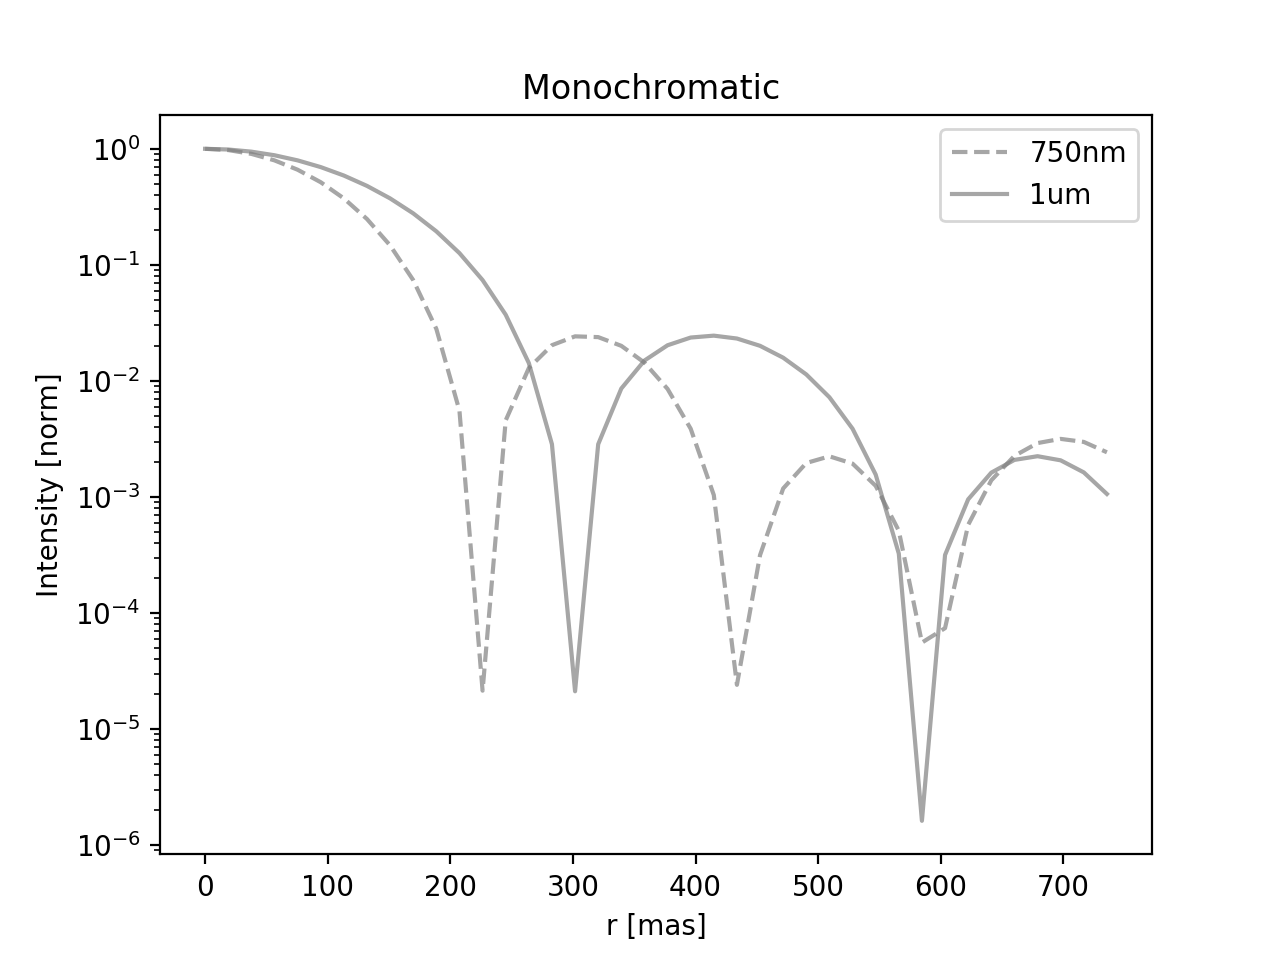

In [29]:
r = np.arange(0,40)*18.86
plt.semilogy(r, psf750, 'gray',linestyle='--',linewidth=1.5, alpha=0.7, label="750nm")
plt.semilogy(r, psf1000,'gray', linewidth=1.5, alpha=0.7, label="1um")
plt.xlabel("r [mas]")
plt.ylabel("Intensity [norm]")
plt.title("Monochromatic ")
plt.legend()
#plt.hlines(1e-3, 0.01, 4,linestyles='--', colors="black")


## ZIMPOL V_730NB

In [11]:
# import filter profile

V730NB = np.genfromtxt("/Users/patapisp/Documents/DAC/ZIMPOL_Mask/SPHERE_Zimpol_730_NB.txt",delimiter=' ')
l, t = zip(*V730NB)
l,t = l[240:330],t[240:330]
lc = 733

<IPython.core.display.Javascript object>


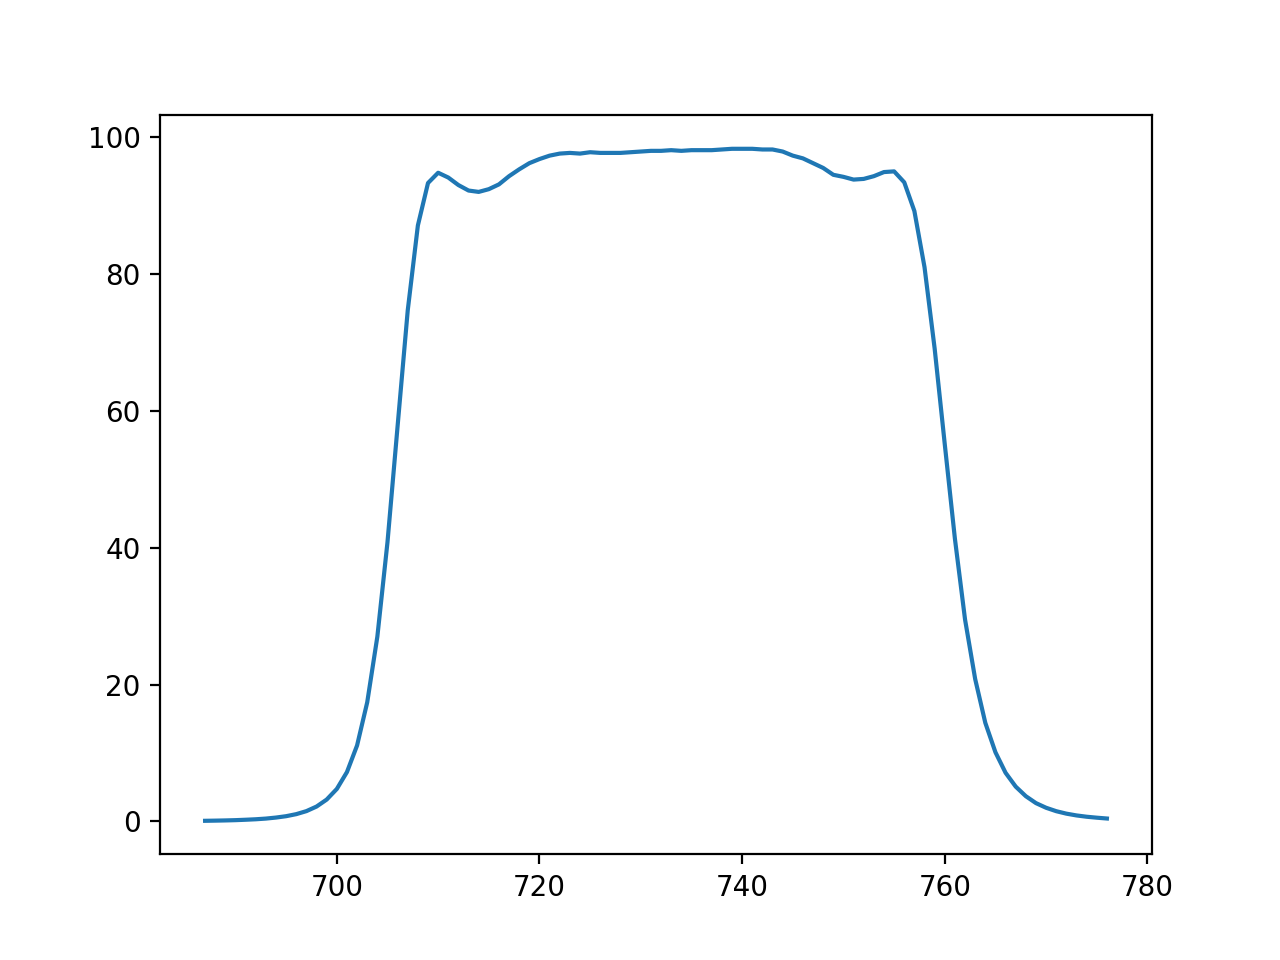

In [12]:
plt.plot(l,t)

Wavelength range [nm] 687.000000 - 776.000000


<IPython.core.display.Javascript object>


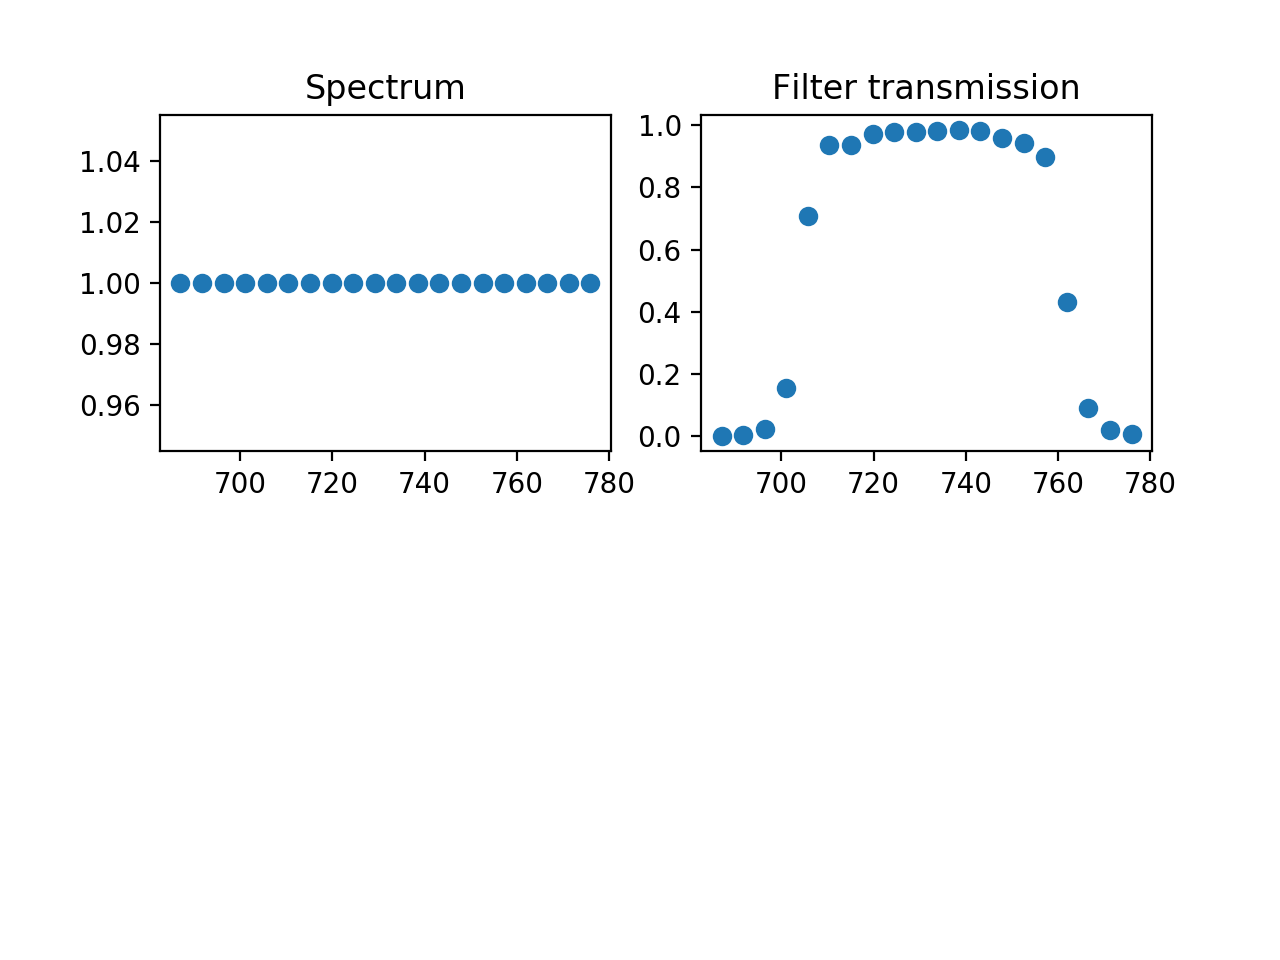

Calculating PSF for VLT @687.000000 nm..


/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


Calculating PSF for VLT @691.684211 nm..
Calculating PSF for VLT @696.368421 nm..
Calculating PSF for VLT @701.052632 nm..
Calculating PSF for VLT @705.736842 nm..
Calculating PSF for VLT @710.421053 nm..
Calculating PSF for VLT @715.105263 nm..
Calculating PSF for VLT @719.789474 nm..
Calculating PSF for VLT @724.473684 nm..
Calculating PSF for VLT @729.157895 nm..
Calculating PSF for VLT @733.842105 nm..
Calculating PSF for VLT @738.526316 nm..
Calculating PSF for VLT @743.210526 nm..
Calculating PSF for VLT @747.894737 nm..
Calculating PSF for VLT @752.578947 nm..
Calculating PSF for VLT @757.263158 nm..
Calculating PSF for VLT @761.947368 nm..
Calculating PSF for VLT @766.631579 nm..
Calculating PSF for VLT @771.315789 nm..
Calculating PSF for VLT @776.000000 nm..
Done. Normalizing..


In [13]:
source_spectrum = np.ones(len(t))

filter_trans = np.array(t)/100.0 #gaussian(np.arange(100),50,40)
PSFbd, PSFoptbd = polychromaticPSF(apRad, N, lc, [l[0], l[-1]],20, source_spectrum, filter_trans, RHO, 
                              strehl=.5, samples=None, aberration=False)



<IPython.core.display.Javascript object>


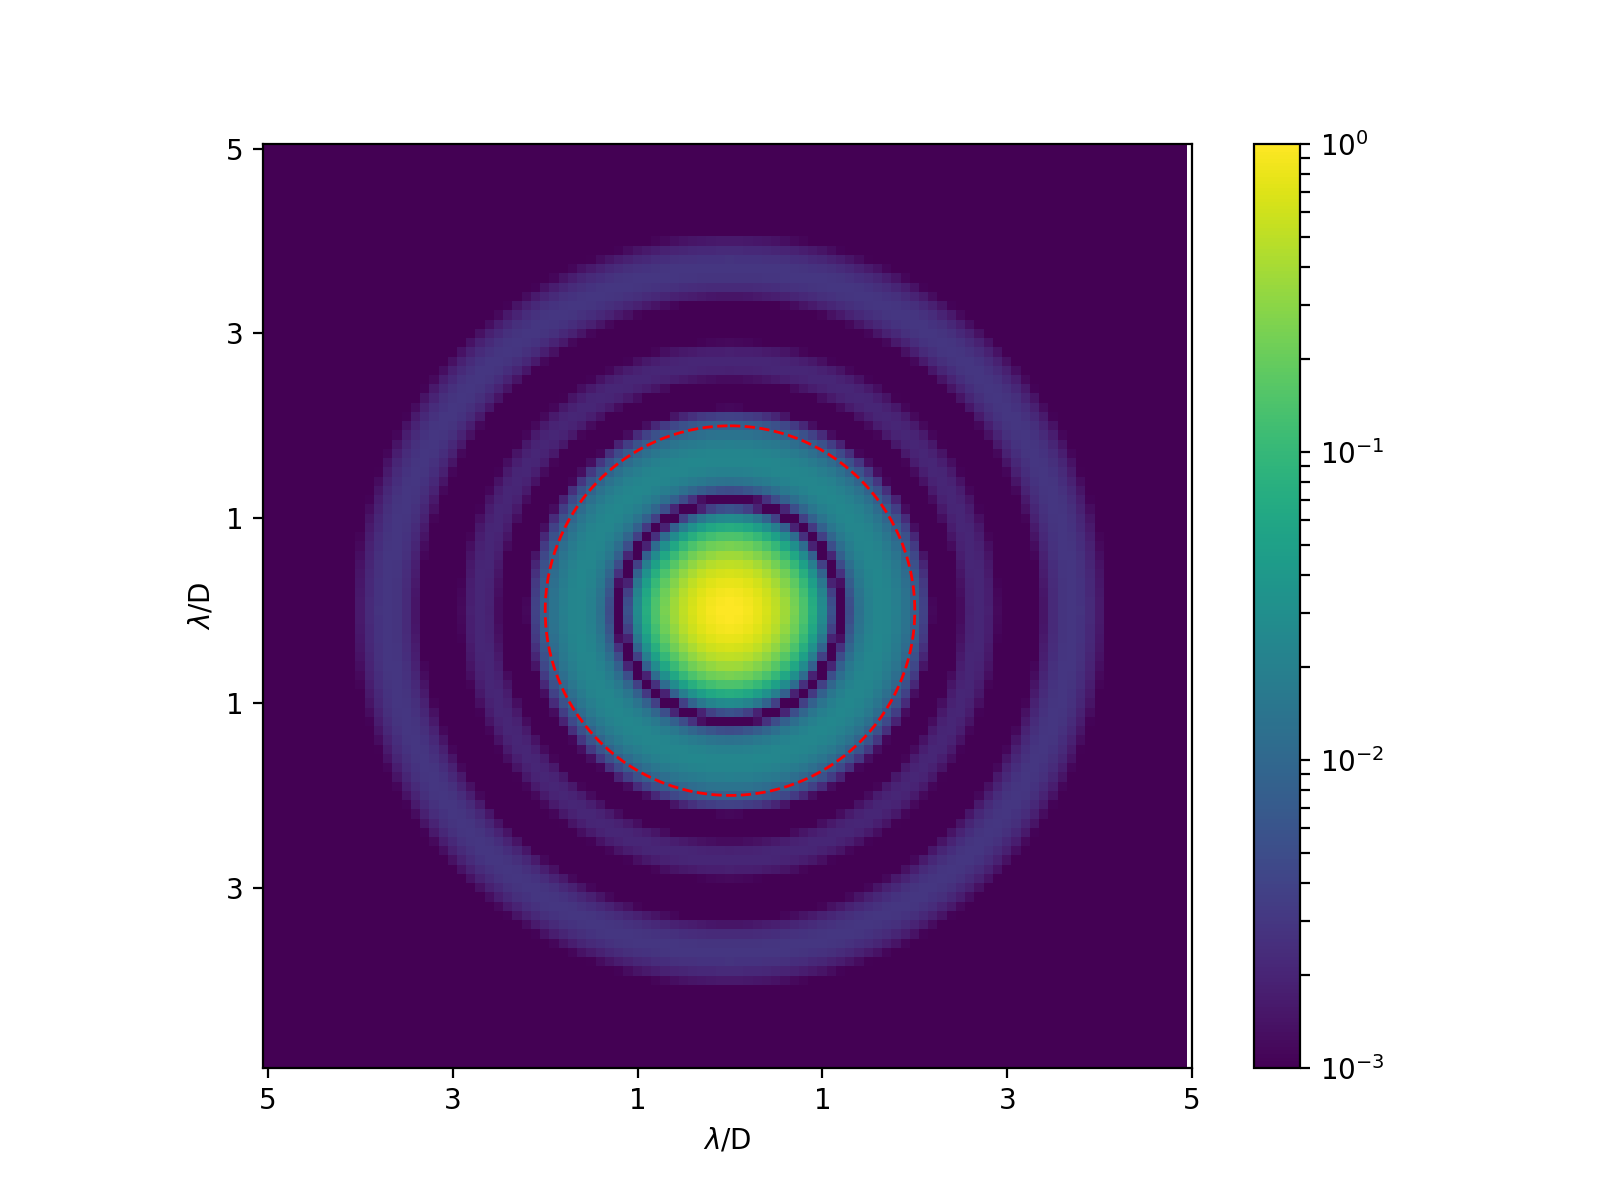

In [14]:
plot_im_ld(PSFbd, lD, 5, log_scale=True, log_min=-3)
plt.xlabel("$\lambda$/D")
plt.ylabel("$\lambda$/D")


<IPython.core.display.Javascript object>


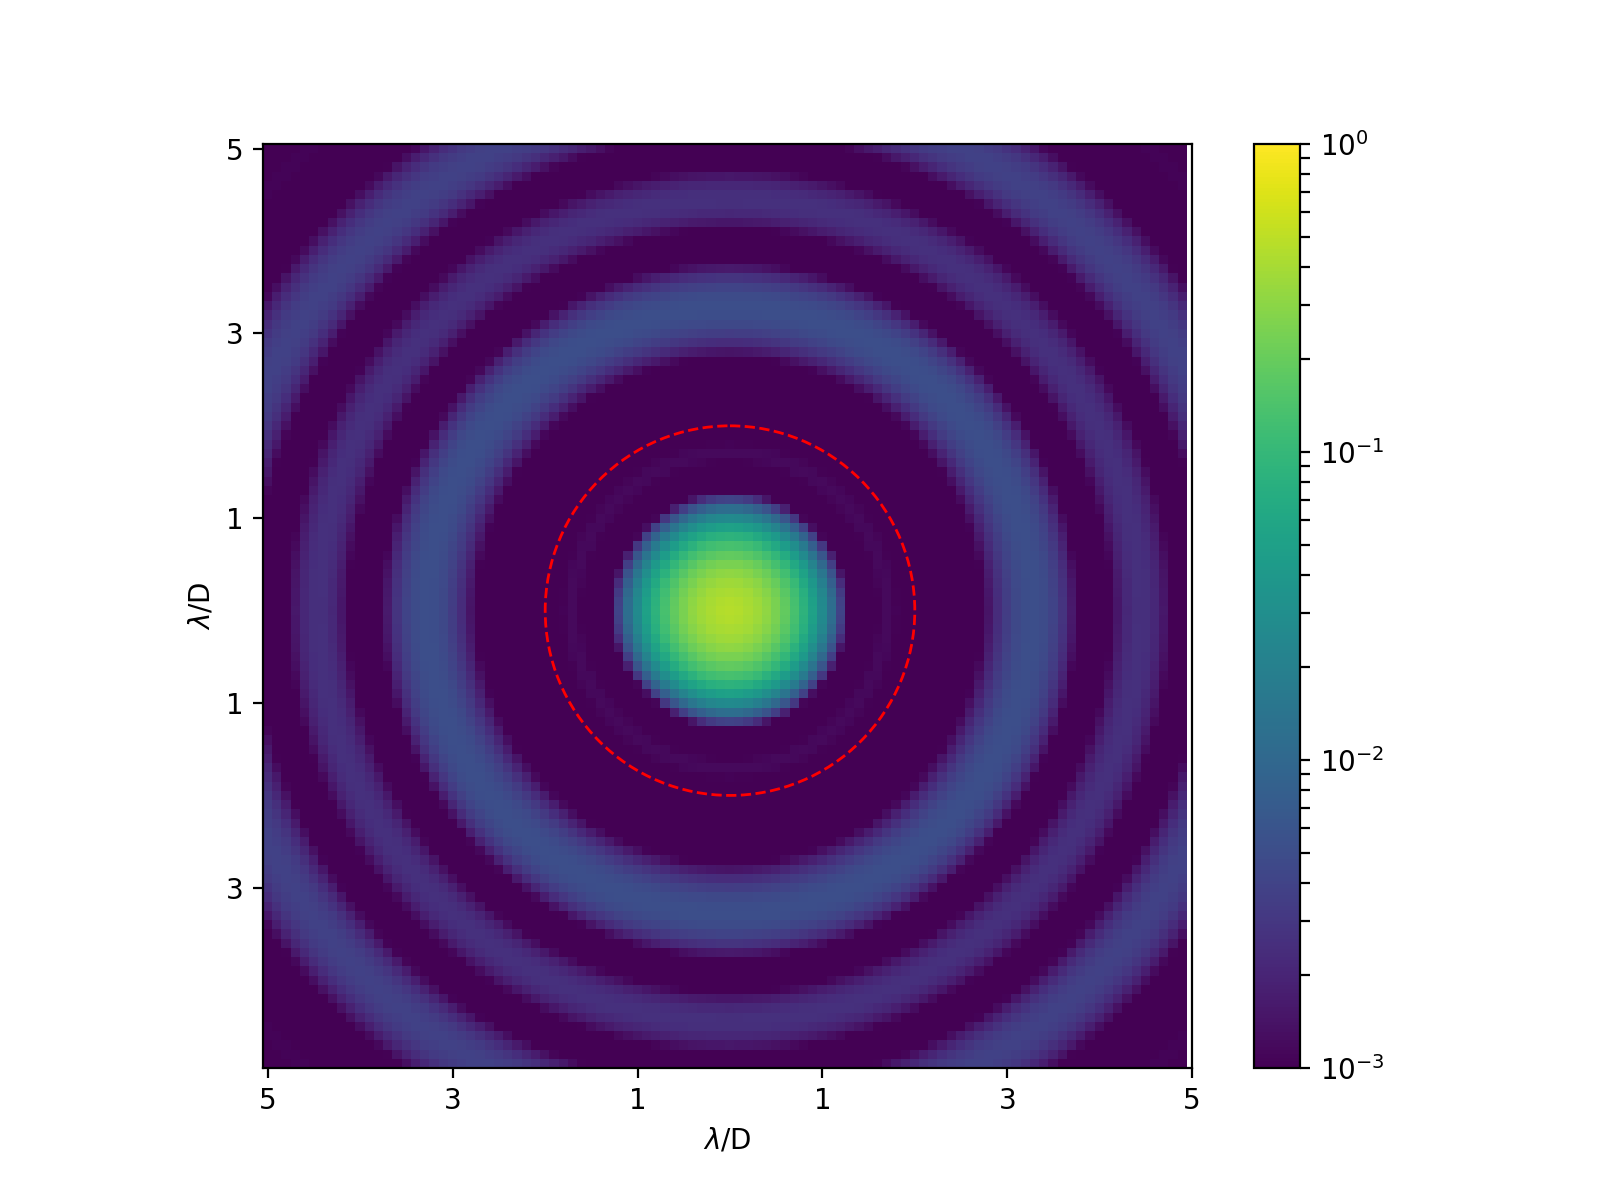

In [15]:
plot_im_ld(PSFoptbd, lD, 5, log_scale=True, log_min=-3)
plt.xlabel("$\lambda$/D")
plt.ylabel("$\lambda$/D")

<IPython.core.display.Javascript object>


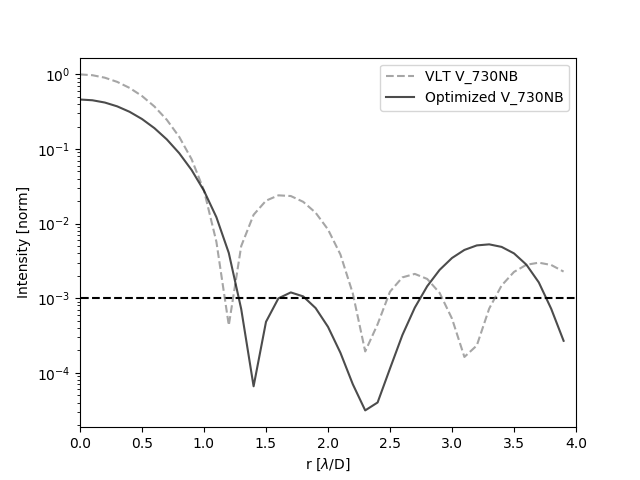

(0, 4)

In [24]:
psf1dbd = np.array([np.mean(PSFbd[np.where(RHO == r)]) for r in np.arange(0,40)])
psfopt1dbd = np.array([np.mean(PSFoptbd[np.where(RHO == r)]) for r in np.arange(0,40)])

plt.semilogy(r, psf1dbd, 'gray',linestyle='--',linewidth=1.5, alpha=0.7, label="VLT V_730NB")
plt.semilogy(r, psfopt1dbd,'black', linewidth=1.5, alpha=0.7, label="Optimized V_730NB")
#plt.grid(True)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Intensity [norm]")
plt.legend()
plt.hlines(1e-3, 0.01, 4,linestyles='--', colors="black")
plt.xlim([0,4])

## Wavefront jitter

In [22]:

wf = gaussian_random_field(size=N)
plt.imshow(wf, cmap='gray')



In [70]:
sigma  = np.sqrt(np.log(1/0.9))
print(sigma)
#sigma = np.pi*30/750

0.32459284597450133


<IPython.core.display.Javascript object>


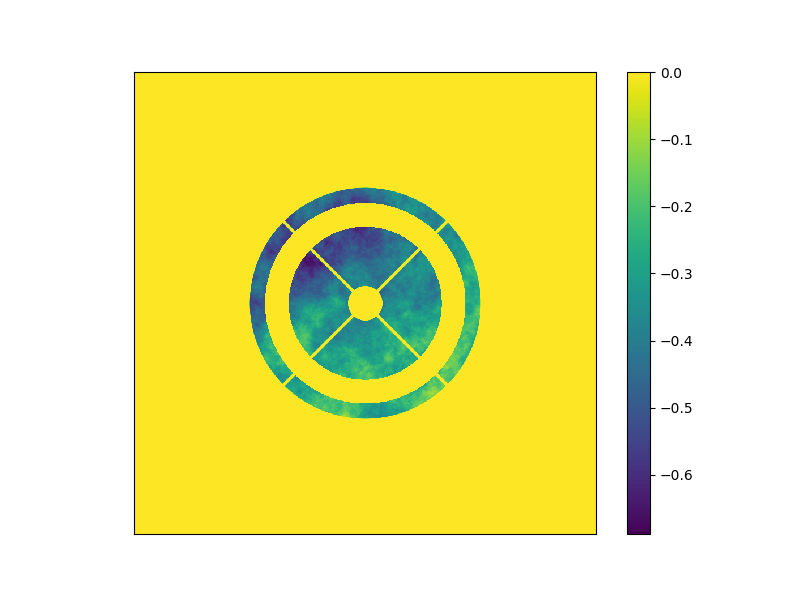

([], <a list of 0 Text xticklabel objects>)

In [74]:
im = EPopt*np.exp(1j*wf*sigma)
#im[np.where(EPopt<1)] = -1.5
plot_im_LP(np.angle(im)*EPopt, apRad, 1, color='viridis')
plt.yticks([])
plt.xticks([])

<IPython.core.display.Javascript object>


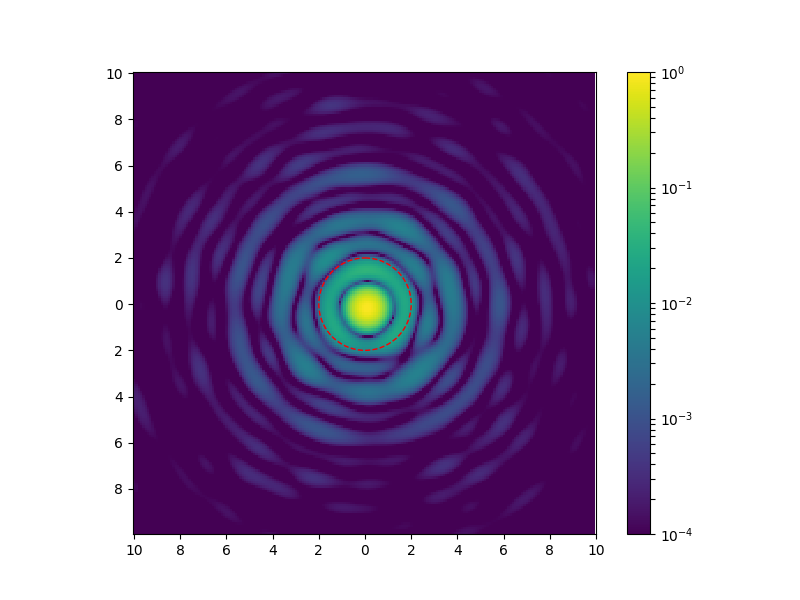

0.961646348955897


In [68]:
PSF_jitter = np.abs(myfft2(EP*np.exp(1j*wf*sigma)))**2/calib
plot_im_ld(PSF_jitter, lD, 10, log_scale=True, log_min=-4)
print(np.max(PSF_jitter))

<IPython.core.display.Javascript object>


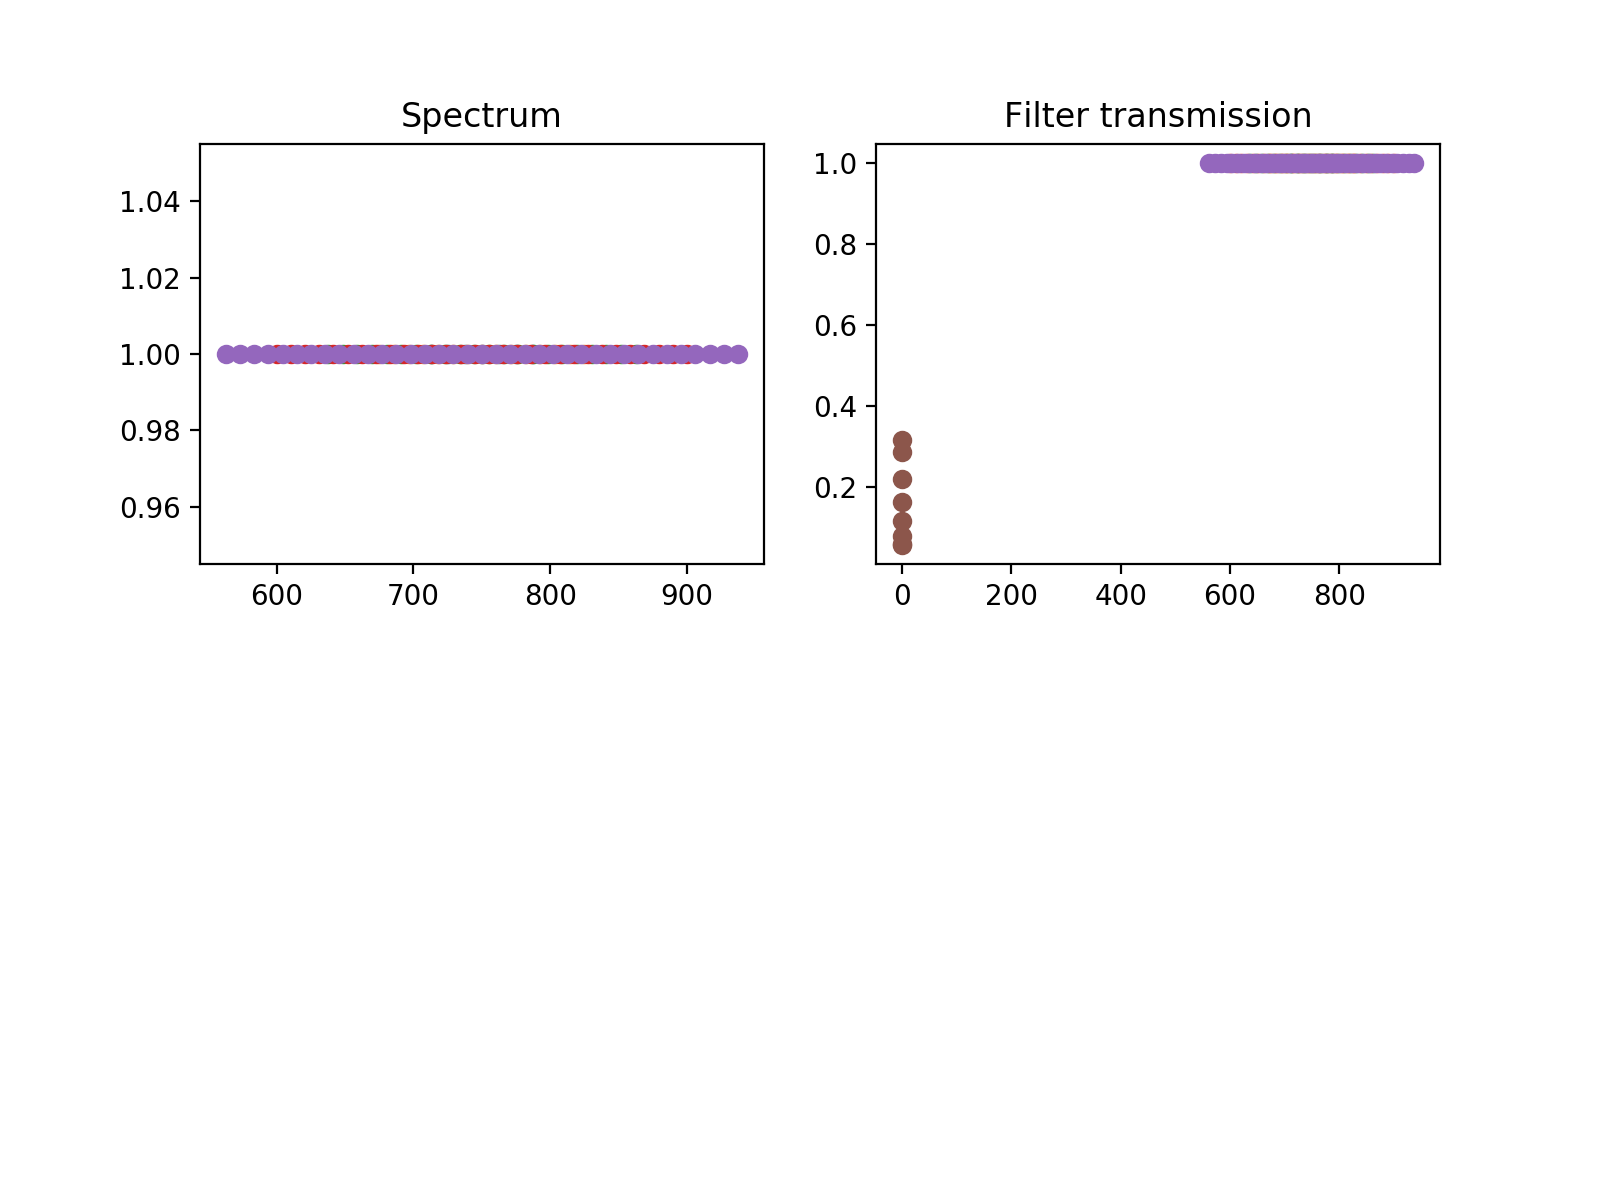

In [37]:
PSFopt_jitter = np.abs(myfft2(EPopt*np.exp(1j*wf*sigma)))**2/calib
plot_im_ld(PSFopt_jitter, lD, 10, log_scale=True, log_min=-3)

In [21]:
psfjit = []
psfoptjit = []
cjit = []
coptjit = []

for s in np.arange(0.3, 1.0,.1):
    sigma  = np.sqrt(np.log(1/s))
    psf = np.abs(myfft2(EP*np.exp(1j*wf*sigma)))**2/calib
    psfopt = np.abs(myfft2(EPopt*np.exp(1j*wf*sigma)))**2/calib
    psfjit.append(psf)
    psfoptjit.append(psfopt)
    cjit.append(np.array([np.mean(psf[np.where(RHO == r)]) for r in np.arange(0,40)]))
    coptjit.append(np.array([np.mean(psfopt[np.where(RHO == r)]) for r in np.arange(0,40)]))
    


NameError: name 'wf' is not defined

<IPython.core.display.Javascript object>


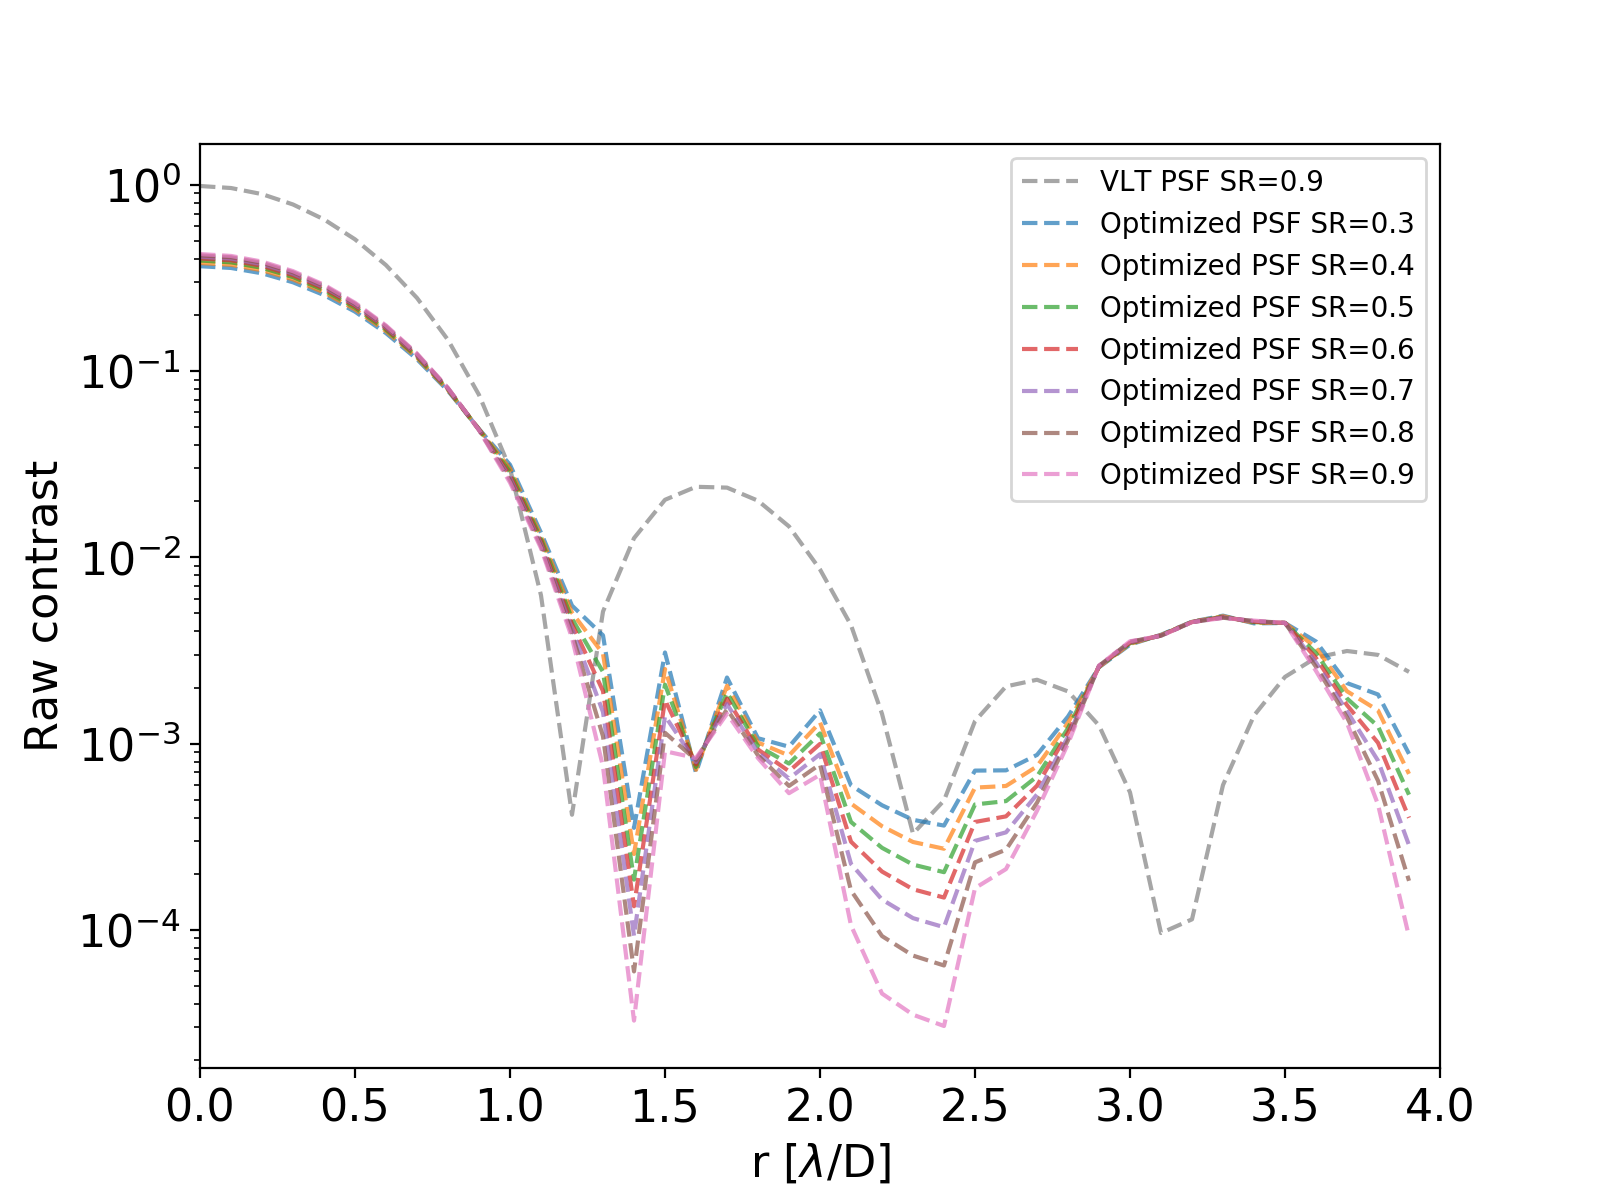

In [50]:
r = np.arange(0,40)/10
fig, ax = plt.subplots(figsize=(8,6))
ax.semilogy(r, cjit[6], 'gray',linestyle='--',linewidth=1.5, alpha=0.7, label="VLT PSF SR=0.9")
s = np.arange(0.3, 1.0,.1)
for i in  range(7):
    contrastROI.append(np.sum(psfoptjit[i][OPT_REG_FP==1])/np.sum(psfjit[i][OPT_REG_FP==1]))
    
    ax.semilogy(r, coptjit[i],linestyle='--',linewidth=1.5, alpha=0.7, label="Optimized PSF SR=%.1f"%(s[i]))

ax.set_xlabel("r [$\lambda$/D]",fontsize=16)
ax.set_ylabel("Raw contrast", fontsize=16)
ax.legend()
ax.set_xlim([0,4])
#ax.hlines(1e-3, 0.01, 4,linestyles='--', colors="black")    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(savepath+"Strehl_contrast.pdf",dpi=300, format='pdf', transparent=True)


<IPython.core.display.Javascript object>


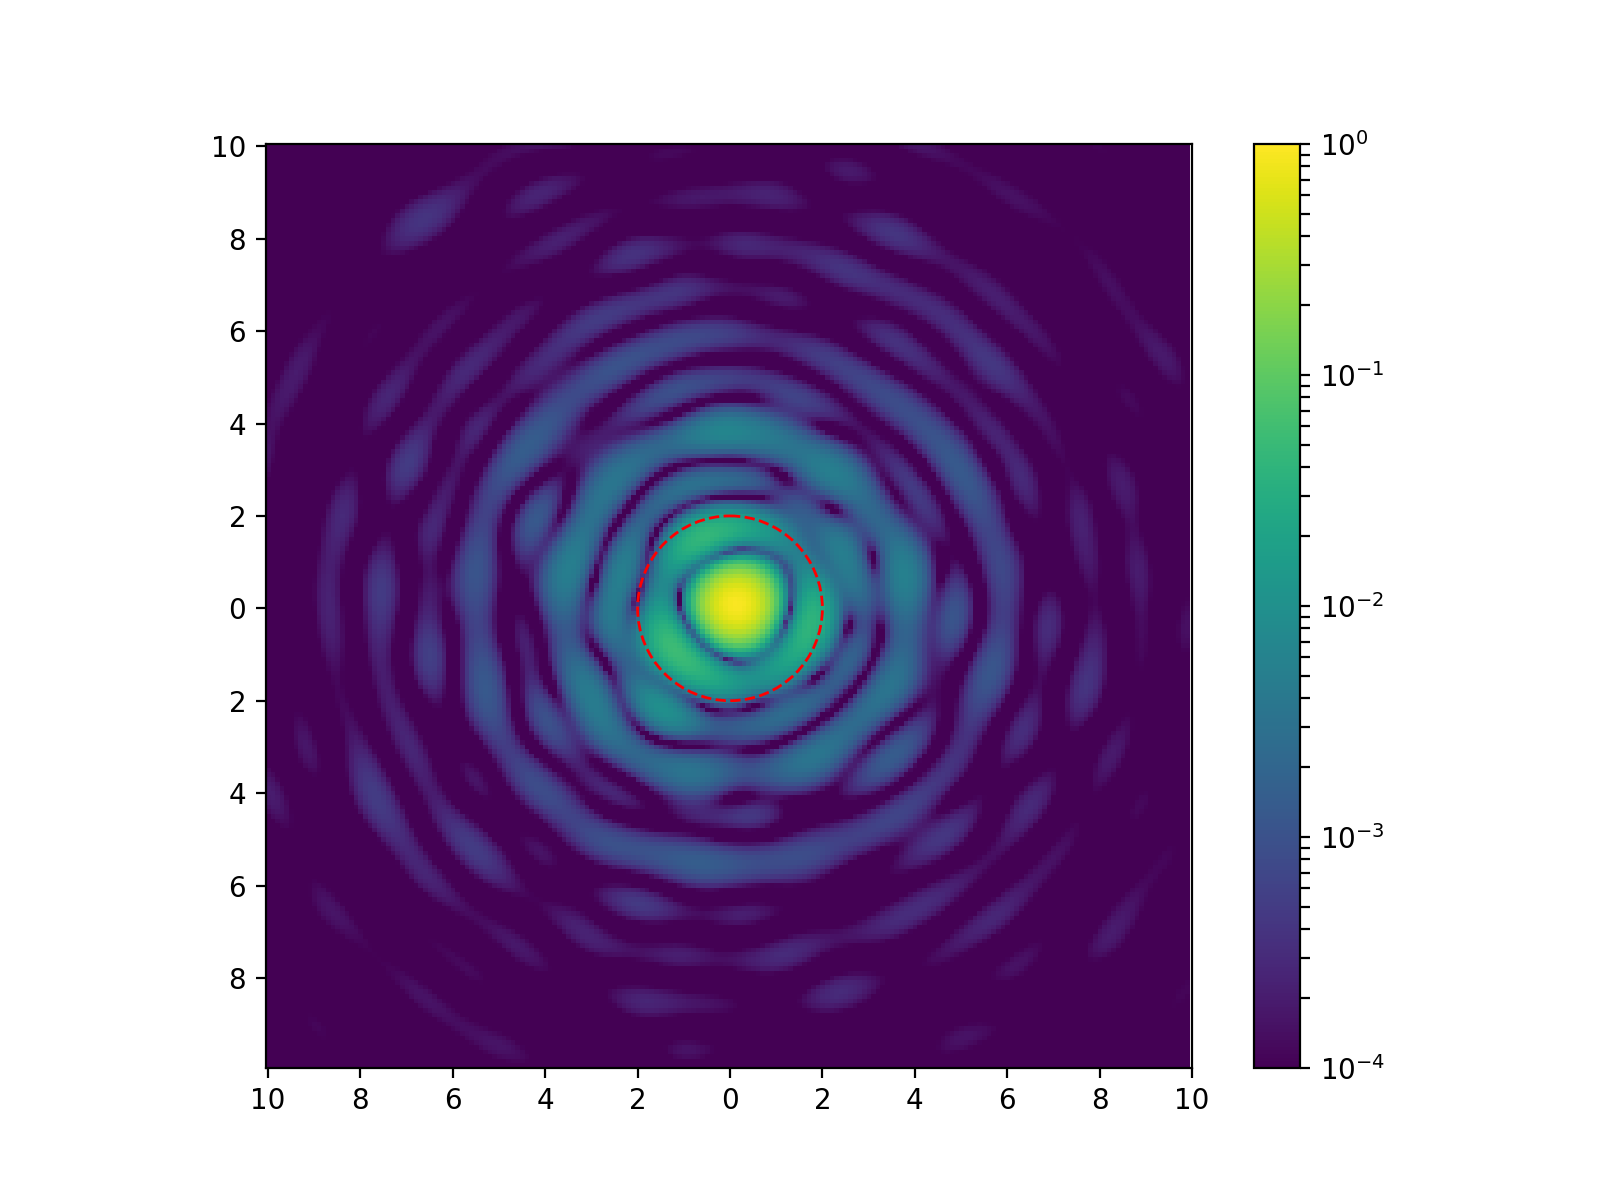

In [48]:
plot_im_ld(psfjit[1], lD, 10, log_scale=True, log_min=-4)

<IPython.core.display.Javascript object>


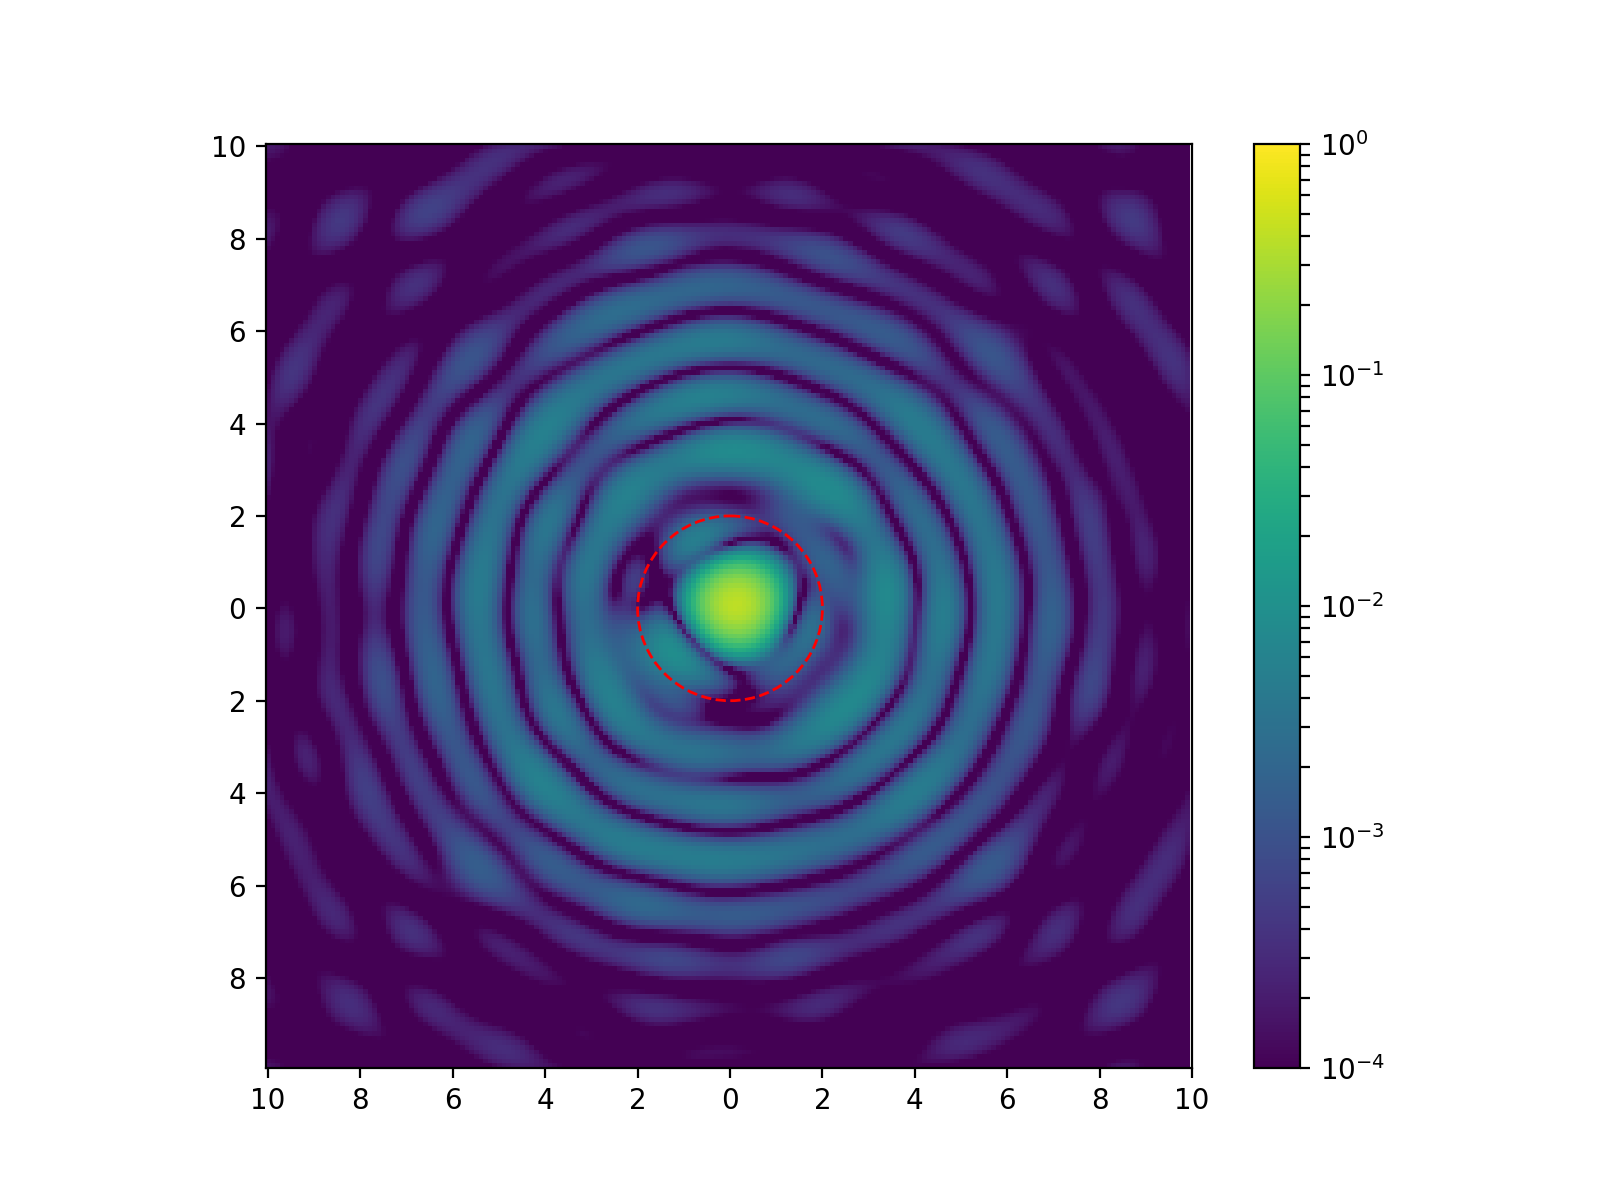

In [49]:
plot_im_ld(psfoptjit[1], lD, 10, log_scale=True, log_min=-4)

<IPython.core.display.Javascript object>


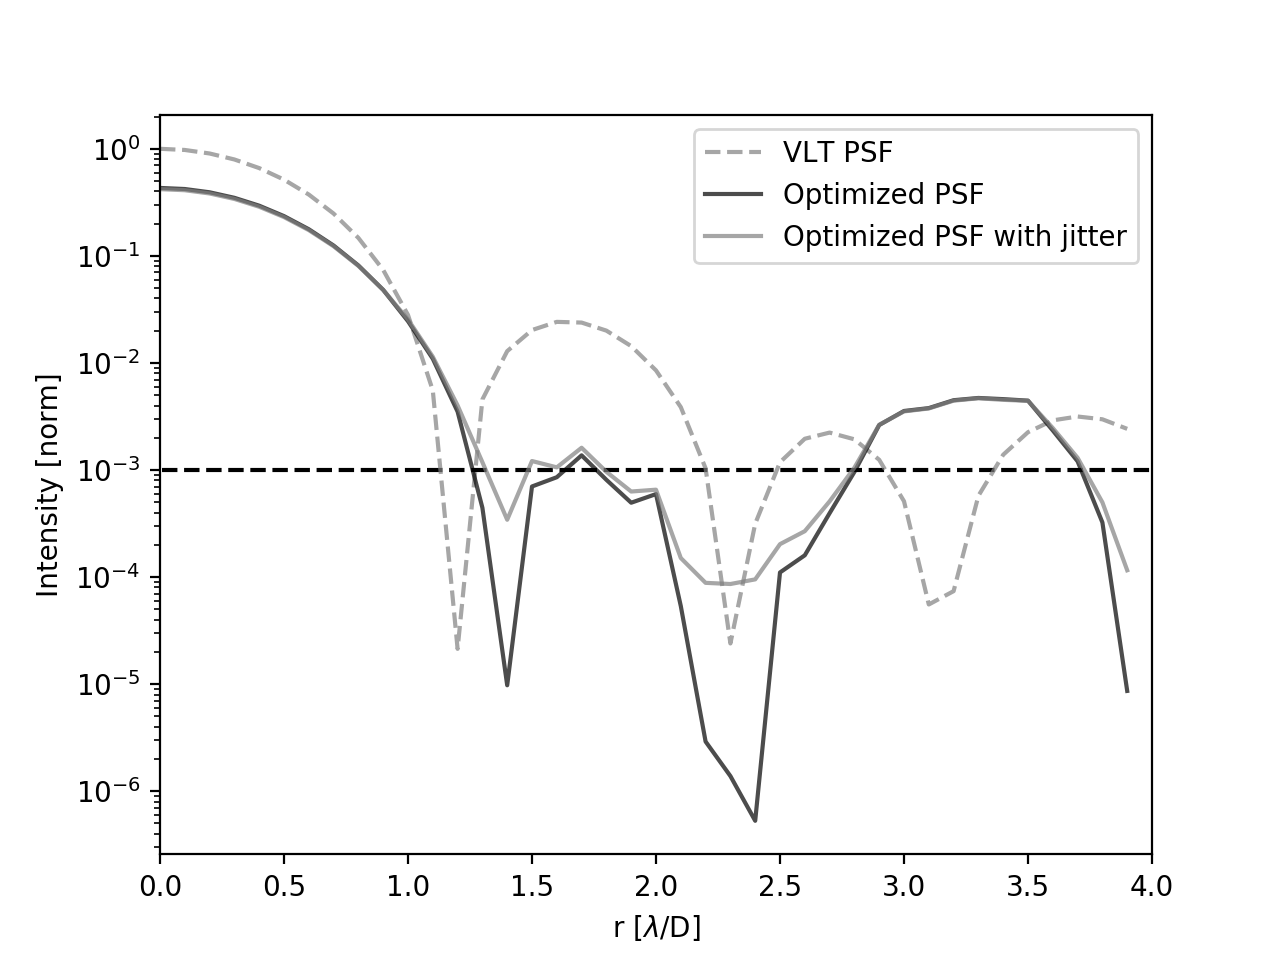

(0, 4)

In [36]:
psf1d = np.array([np.mean(PSF[np.where(RHO == r)]/calib) for r in np.arange(0,40)])
psfopt1d = np.array([np.mean(PSFopt[np.where(RHO == r)]) for r in np.arange(0,40)])
psfopt1djitter = np.array([np.mean(PSF_jitter[np.where(RHO == r)]) for r in np.arange(0,40)])

r = np.arange(0,40)/10
plt.semilogy(r, psf1d, 'gray',linestyle='--',linewidth=1.5, alpha=0.7, label="VLT PSF")
plt.semilogy(r, psfopt1d,'black', linewidth=1.5, alpha=0.7, label="Optimized PSF")
plt.semilogy(r,psfopt1djitter,'gray', linewidth=1.5, alpha=0.7, label="Optimized PSF with jitter")

#plt.grid(True)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Intensity [norm]")
plt.legend()
plt.hlines(1e-3, 0.01, 4,linestyles='--', colors="black")
plt.xlim([0,4])

## ZIMPOL V_730NB with jitter 

Wavelength range [nm] 687.000000 - 776.000000


<IPython.core.display.Javascript object>


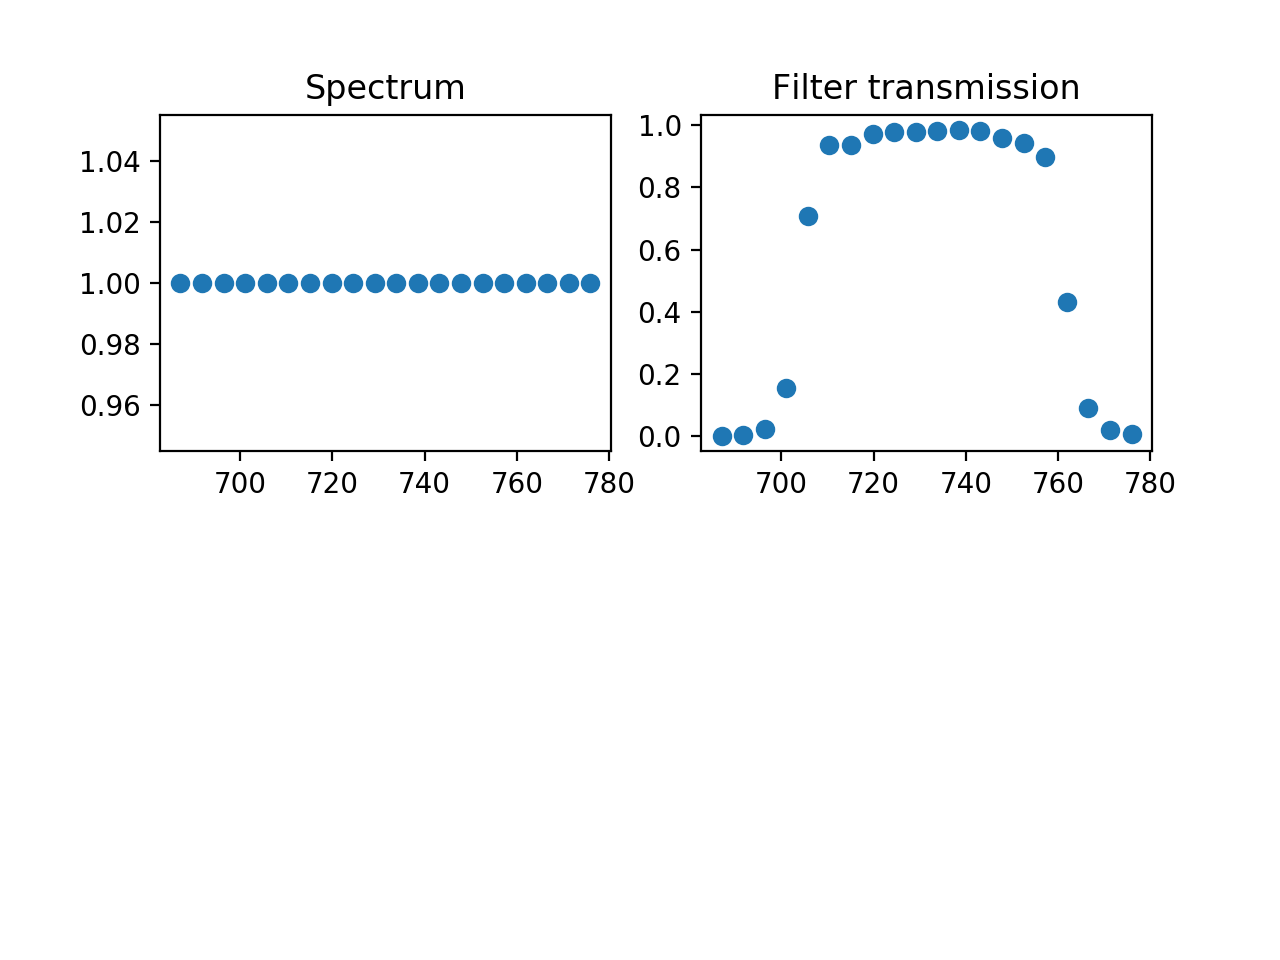

Calculating PSF for VLT @687.000000 nm..


/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


Calculating PSF for VLT @691.684211 nm..
Calculating PSF for VLT @696.368421 nm..
Calculating PSF for VLT @701.052632 nm..
Calculating PSF for VLT @705.736842 nm..
Calculating PSF for VLT @710.421053 nm..
Calculating PSF for VLT @715.105263 nm..
Calculating PSF for VLT @719.789474 nm..
Calculating PSF for VLT @724.473684 nm..
Calculating PSF for VLT @729.157895 nm..
Calculating PSF for VLT @733.842105 nm..
Calculating PSF for VLT @738.526316 nm..
Calculating PSF for VLT @743.210526 nm..
Calculating PSF for VLT @747.894737 nm..
Calculating PSF for VLT @752.578947 nm..
Calculating PSF for VLT @757.263158 nm..
Calculating PSF for VLT @761.947368 nm..
Calculating PSF for VLT @766.631579 nm..
Calculating PSF for VLT @771.315789 nm..
Calculating PSF for VLT @776.000000 nm..
Done. Normalizing..


In [10]:
source_spectrum = np.ones(len(t))

filter_trans = np.array(t)/100.0

PSFbd, PSFoptbd = polychromaticPSF(apRad, N, lc, [l[0], l[-1]],20, source_spectrum, filter_trans, RHO, 
                               strehl=0.7, samples=None, aberration=wf)



<IPython.core.display.Javascript object>


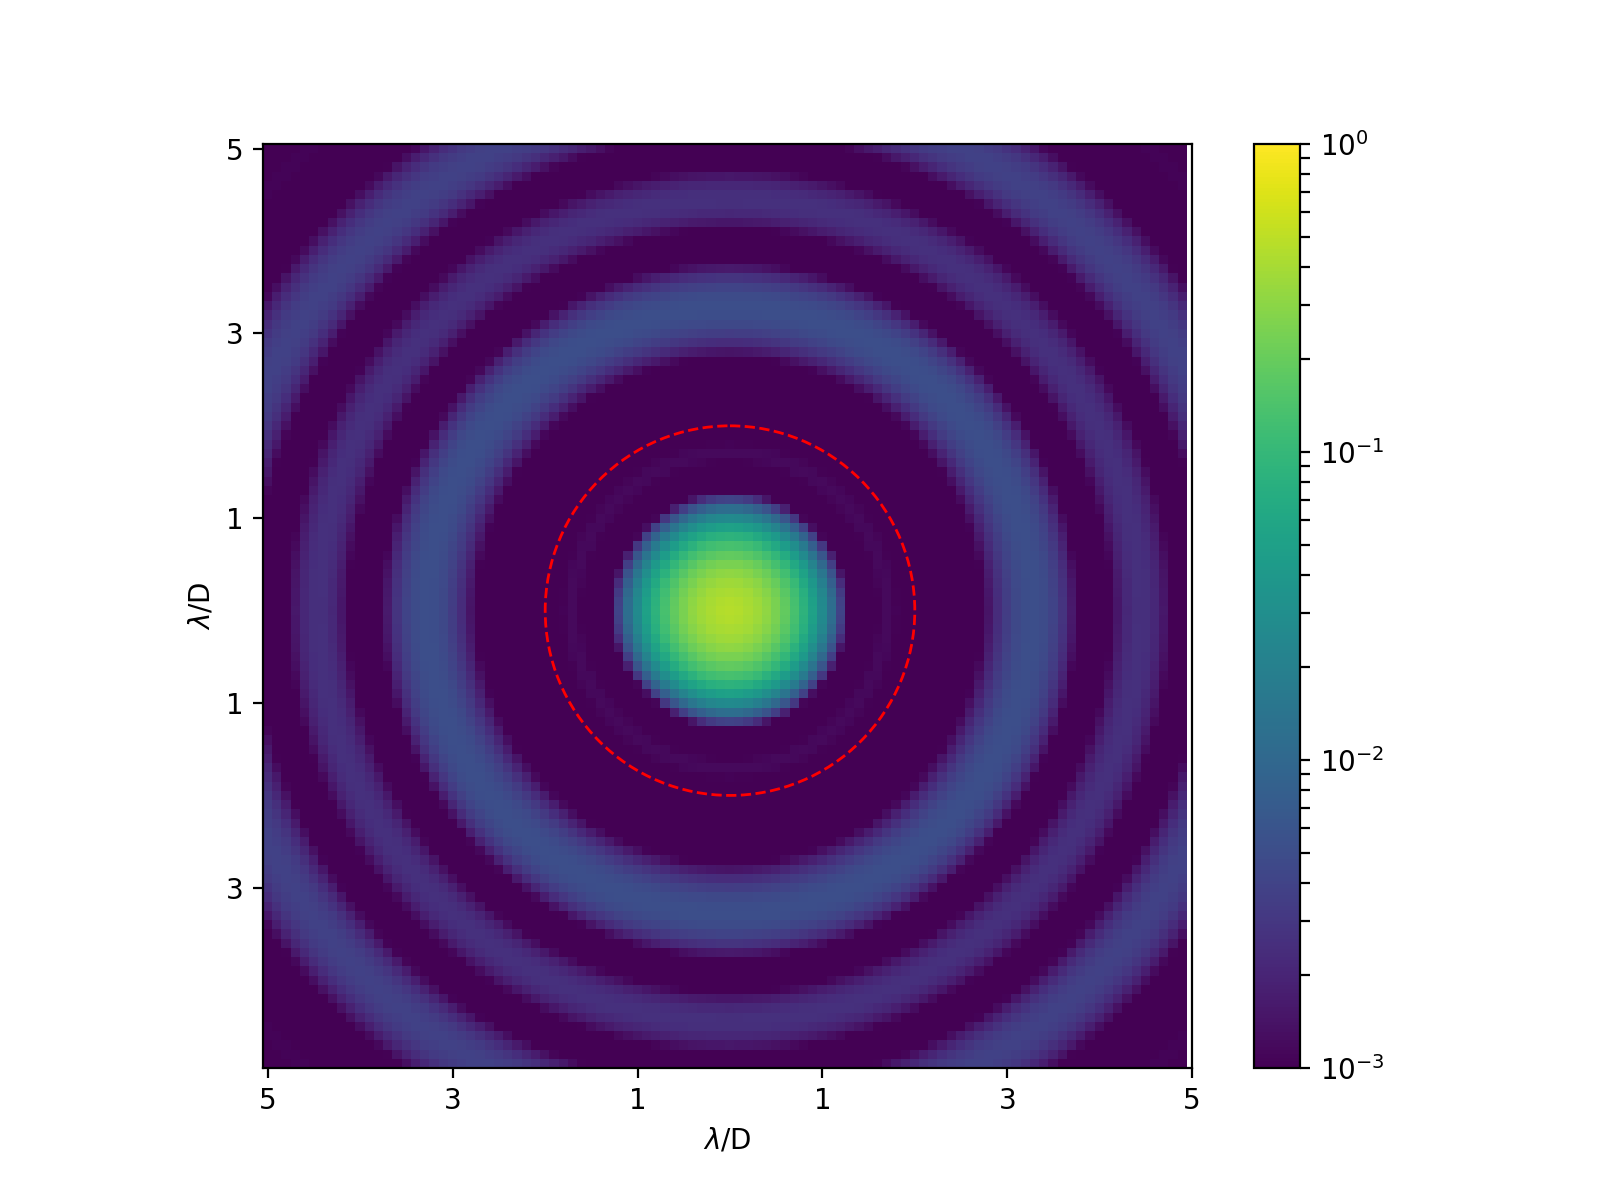

In [11]:
plot_im_ld(PSFoptbd, lD, 5, log_scale=True, log_min=-3)
plt.xlabel("$\lambda$/D")
plt.ylabel("$\lambda$/D")

## Pupil registration

In [61]:
PSF = abs(myfft2(EP))**2
calib = np.max(PSF)
PSF /= calib
c = [np.sum(PSFopt[np.where(OPT_REG_FP==1)])/np.sum(PSF[np.where(OPT_REG_FP==1)])]
for pix in [1, 5, 10, 15, 20, 30, 40]:
    EPopt_shift = np.roll(EPopt, pix, axis=1)
    EPopt_shift = np.roll(EPopt_shift,pix, axis=0)*EP
    PSFshift = abs(myfft2(EPopt_shift))**2/calib
    c.append(np.sum(PSFshift[np.where(OPT_REG_FP==1)])/np.sum(PSF[np.where(OPT_REG_FP==1)]))
    
plt.plot(np.array([0, 1, 5, 10, 15, 20, 30, 40])/apRad, c, 'o')

<IPython.core.display.Javascript object>


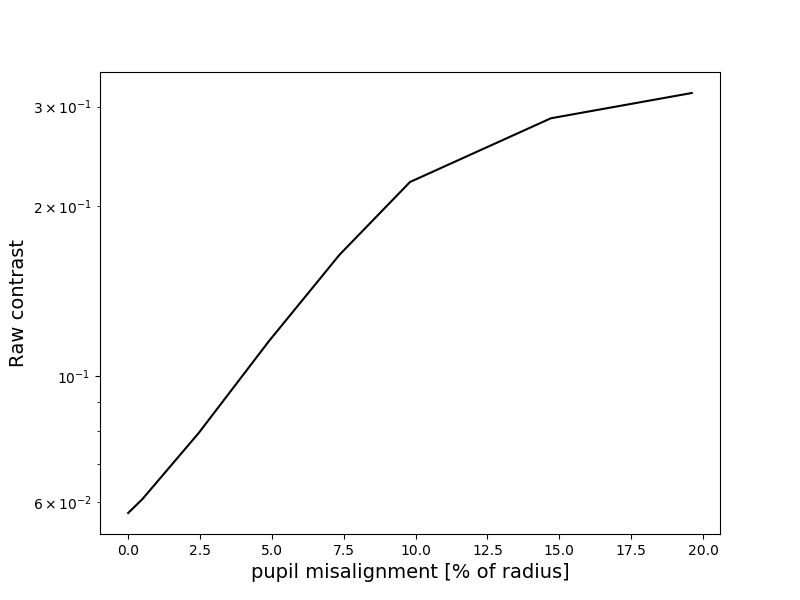

In [78]:
plt.figure(figsize=(8,6))
plt.semilogy(np.array([0,1, 5, 10, 15, 20, 30, 40])*100/apRad, c, color='black')
plt.xlabel("pupil misalignment [% of radius]",fontsize=14)
plt.ylabel("Raw contrast", fontsize=14)
plt.savefig(savepath+"pupil-misalignment.pdf",dpi=300, format='pdf', transparent=True)

